In [1]:
import importlib

import numpy as np
import pandas as pd
import scipy
from scipy.stats import pearsonr

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import logomaker as lm

import tensorflow as tf

from Modules import utils, tf_utils, plot_utils
from Modules.tf_utils import mae_cor, correlate, get_profile
import kMC_sequence_design
from kMC_sequence_design import get_profile_hint, rmse, GC_energy, get_profile_chunk

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# sns.set_theme()

2023-12-11 22:57:24.061337: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
importlib.reload(utils)
importlib.reload(tf_utils)
importlib.reload(plot_utils)
importlib.reload(kMC_sequence_design)

<module 'kMC_sequence_design' from '/home/alex/mnhn-internship_DeepCNN_ChIP-seq/kMC_sequence_design.py'>

Models

In [2]:
model_pol_name = 'model_myco_pol_17'
# with tf.distribute.MirroredStrategy().scope():
model_pol = tf.keras.models.load_model(f'/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_pol_name}/model',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_nuc_name = 'model_myco_nuc_2'
model_nuc = tf.keras.models.load_model(f'/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_nuc_name}/model',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_coh_name = 'model_myco_coh_14'
model_coh = tf.keras.models.load_model(f'/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_coh_name}/model',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_rna_name = 'weight_CNN_RNA_seq_2001_12_8_4_SRR7131299' # order 'ATGC'
model_rna = tf.keras.models.load_model(f'/home/alex/shared_folder/JB_seqdes/{model_rna_name}.hdf5',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_nuc_etienne_name = 'weights_with_rev_compl_rep2'
model_nuc_etienne = tf.keras.models.load_model(f'/home/alex/shared_folder/JB_seqdes/{model_nuc_etienne_name}.hdf5',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_rna.input_shape

2023-12-11 22:57:28.866343: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-12-11 22:57:28.980398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-11 22:57:28.981023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-12-11 22:57:28.981070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-11 22:57:28.981668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID

(None, 2001, 4, 1)

In [3]:
myco_rna_1_fwd = utils.load_bw('/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703670_RNAseq_Mmyco_rep1.fwd-CPM.bw')
myco_rna_1_rev = utils.load_bw('/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703670_RNAseq_Mmyco_rep1.rev-CPM.bw')

In [4]:
with np.load('/home/alex/shared_folder/SCerevisiae/results/weight_CNN_RNA_seq_2001_12_8_4_SRR7131299/preds_weight_CNN_RNA_seq_2001_12_8_4_SRR7131299_on_W303_Mmmyco.npz') as f:
    preds_rna = {k: f[k] for k in f.keys()}
with np.load('/home/alex/shared_folder/SCerevisiae/results/weight_CNN_RNA_seq_2001_12_8_4_SRR7131299/preds_weight_CNN_RNA_seq_2001_12_8_4_SRR7131299_on_S288c_Mpneumo.npz') as f:
    preds_rna['Mpneumo'] = f['Mpneumo']
    preds_rna['Mpneumo_rev'] = f['Mpneumo_rev']
print(list(preds_rna.keys()))

['chrI', 'chrI_rev', 'chrII', 'chrII_rev', 'chrIII', 'chrIII_rev', 'chrIV', 'chrIV_rev', 'chrV', 'chrV_rev', 'chrVI', 'chrVI_rev', 'chrVII', 'chrVII_rev', 'chrVIII', 'chrVIII_rev', 'chrIX', 'chrIX_rev', 'chrX', 'chrX_rev', 'chrXI', 'chrXI_rev', 'chrXII', 'chrXII_rev', 'chrXIII', 'chrXIII_rev', 'chrXIV', 'chrXIV_rev', 'chrXV', 'chrXV_rev', 'chrXVI', 'chrXVI_rev', 'Mmmyco', 'Mmmyco_rev', 'Mpneumo', 'Mpneumo_rev']


0.2892304308533576 0.2521805496129201


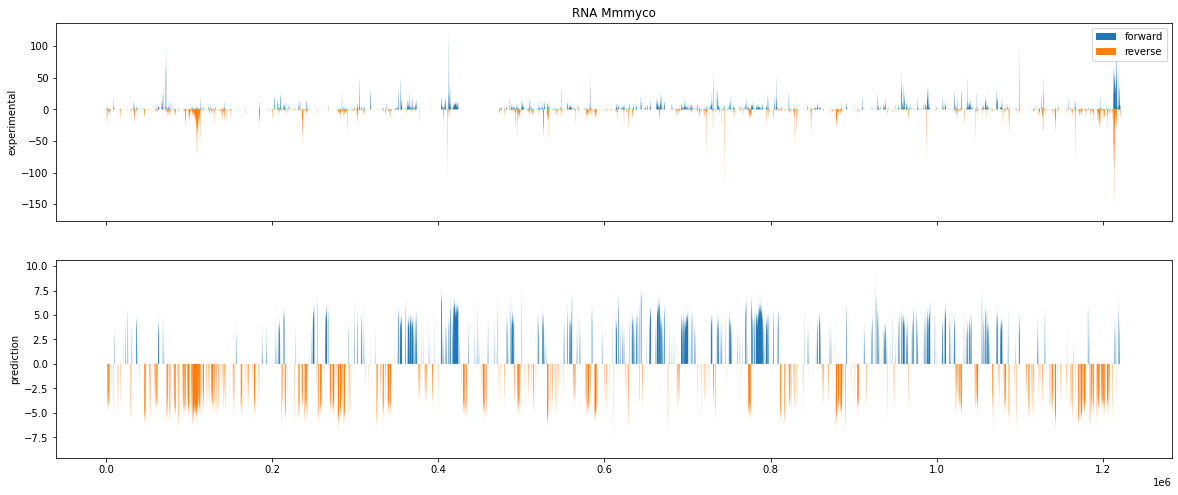

In [36]:
chr_id = 'Mmmyco'
start = 0 # 320_000
stop = start + 2_000_000
exp_clip_max = np.inf

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 8), facecolor='w')
stop = min(stop, len(myco_rna_1_fwd[chr_id]))
axes[0].set_title(f'RNA {chr_id}')
axes[0].fill_between(np.arange(start, stop), np.clip(myco_rna_1_fwd[chr_id][start:stop], None, exp_clip_max), label='forward')
axes[0].fill_between(np.arange(start, stop), -np.clip(myco_rna_1_rev[chr_id][start:stop], None, exp_clip_max), label='reverse')
axes[0].set_ylabel('experimental')
axes[0].legend()
axes[1].fill_between(np.arange(start, stop), preds_rna[chr_id][start:stop])
axes[1].fill_between(np.arange(start, stop), -preds_rna[f'{chr_id}_rev'][start:stop])
axes[1].set_ylabel('prediction')
print(pearsonr(myco_rna_1_fwd[chr_id][start:stop], preds_rna[chr_id][start:stop])[0], pearsonr(myco_rna_1_rev[chr_id][start:stop], preds_rna[f'{chr_id}_rev'][start:stop])[0])

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, n_informative=2,
                       random_state=0, shuffle=False)
print(X.shape, y.shape)
print(X, y)
# regr = RandomForestRegressor(max_depth=2, random_state=0)
# regr.fit(X, y)
# print(regr.predict([[0, 0, 0, 0]]))

(100, 4) (100,)
[[ 1.76405235  0.40015721  0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323  0.33367433]
 [ 1.49407907 -0.20515826  0.3130677  -0.85409574]
 [-2.55298982  0.6536186   0.8644362  -0.74216502]
 [ 2.26975462 -1.45436567  0.04575852 -0.18718385]
 [ 1.53277921  1.46935877  0.15494743  0.37816252]
 [-0.88778575 -1.98079647 -0.34791215  0.15634897]
 [ 1.23029068  1.20237985 -0.38732682 -0.30230275]
 [-1.04855297 -1.42001794 -1.70627019  1.9507754 ]
 [-0.50965218 -0.4380743  -1.25279536  0.77749036]
 [-1.61389785 -0.21274028 -0.89546656  0.3869025 ]
 [-0.51080514 -1.18063218 -0.02818223  0.42833187]
 [ 0.06651722  0.3024719  -0.63432209 -0.36274117]
 [-0.67246045 -0.35955316 -0.81314628 -1.7262826 ]
 [ 0.17742614 -0.40178094 -1.63019835  0.46278226]
 [-0.90729836  0.0519454   0.72909056  0.12898291]
 [ 1.13940068 -1.23482582  0.40234164 -0.68481009]
 [-0.87079715 -

In [39]:
help(make_regression)

Help on function make_regression in module sklearn.datasets._samples_generator:

make_regression(n_samples=100, n_features=100, *, n_informative=10, n_targets=1, bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, shuffle=True, coef=False, random_state=None)
    Generate a random regression problem.
    
    The input set can either be well conditioned (by default) or have a low
    rank-fat tail singular profile. See :func:`make_low_rank_matrix` for
    more details.
    
    The output is generated by applying a (potentially biased) random linear
    regression model with `n_informative` nonzero regressors to the previously
    generated input and some gaussian centered noise with some adjustable
    scale.
    
    Read more in the :ref:`User Guide <sample_generators>`.
    
    Parameters
    ----------
    n_samples : int, default=100
        The number of samples.
    
    n_features : int, default=100
        The number of features.
    
    n_informative : int, default

In [37]:
pd.DataFrame({k: pd.Series(v).describe(percentiles=[0.75, 0.9, 0.95, 0.99]) for k, v in myco_rna_1_fwd.items()})

chrI          chrII         chrIII         chrIV  \
count  245675.000000  818518.000000  347597.000000  1.548464e+06   
mean       22.248615      14.517539      14.875845  1.889176e+01   
std       120.722229      38.905087      41.683041  4.636654e+01   
min         0.000000       0.000000       0.000000  0.000000e+00   
50%         1.926610       2.568810       1.926610  2.889910e+00   
75%         9.633030      13.165100      12.844000  1.798170e+01   
90%        34.678902      36.284401      39.495399  4.977070e+01   
95%        61.330299      64.862396      73.210999  8.701840e+01   
99%       319.174011     162.156006     158.623993  2.157800e+02   
max      2293.139893     686.995972     788.624023  9.100000e+02   

                chrV          chrVI        chrVII        chrVIII  \
count  590080.000000  271173.000000  1.090383e+06  580970.000000   
mean       21.592367      13.231630  2.310941e+01      19.635641   
std        66.660606      24.828255  5.242729e+01      69.961243   
min         0.000000       0.000000  0.000000e+00       0.000000   
50%         2.889910       1.926610  3.853210e+00       2.568810   
75%        17.018400      16.697300  2.279820e+01      18.623899   
90%        56.513802      41.743099  5.908260e+01      50.412899   
95%       106.606003      57.477100  1.069270e+02      77.385300   
99%       227.981995     118.165001  2.710090e+02     194.908005   
max      2013.790039     333.303009  7.786700e+02    1630.709961   

               chrIX           chrX          chrXI        chrXII  \
count  429631.000000  751537.000000  678555.000000  1.103351e+06   
mean       14.383053      16.331224      22.641867  2.123807e+01   
std        37.501408      51.526096      65.387108  7.152475e+01   
min         0.000000       0.000000       0.000000  0.000000e+00   
50%         2.247710       2.568810       3.211010  2.247710e+00   
75%        13.807300      15.091700      21.192699  1.605510e+01   
90%        39.495399      36.926601      54.266102  4.366970e+01   
95%        61.651402      66.467903      81.559700  7.674310e+01   
99%       144.173996     198.119003     394.632996  3.736010e+02   
max       835.664978    1165.280029     890.734009  1.194500e+03   

             chrXIII         chrXIV         chrXV         chrXVI        Mmmyco  
count  932757.000000  777478.000000  1.091404e+06  932221.000000  1.222199e+06  
mean       18.401682      19.229990  1.810861e+01      21.455156  1.630846e+00  
std        45.592159      40.985580  4.069138e+01      57.643066  5.620840e+00  
min         0.000000       0.000000  0.000000e+00       0.000000  0.000000e+00  
50%         2.889910       4.174310  3.211010e+00       3.532110  0.000000e+00  
75%        17.660601      21.513800  1.862390e+01      20.229401  6.422020e-01  
90%        47.201900      50.734001  5.201840e+01      52.660599  4.174310e+00  
95%        75.779800      84.128502  8.284410e+01      90.871597  8.348630e+00  
99%       213.210999     183.669998  1.852750e+02     275.183990  2.665140e+01  
max       807.086975     760.528015  9.509410e+02    1071.839966  1.225000e+02

In [29]:
exp_clip_max = 100
for chr_id in myco_rna_1_fwd.keys():
    print(chr_id,
          pearsonr(np.clip(myco_rna_1_fwd[chr_id], None, exp_clip_max), preds_rna[chr_id])[0],
          pearsonr(np.clip(myco_rna_1_rev[chr_id], None, exp_clip_max), preds_rna[f'{chr_id}_rev'])[0])

chrI 0.6225807454473237 0.5927560757642651
chrII 0.6238636438395673 0.686326015171975
chrIII 0.6515302197996375 0.6751663949134261
chrIV 0.6597461416495914 0.6569229627856449
chrV 0.672907444219743 0.6774149422343421
chrVI 0.6645463093837977 0.6384164260999712
chrVII 0.6933640266730127 0.7179020206396227
chrVIII 0.690819487696634 0.6566845708688511
chrIX 0.6339519522711458 0.6398155366732914
chrX 0.6661034467217879 0.667064221536243
chrXI 0.7006508910594113 0.6550300161604607
chrXII 0.6825770251708088 0.6360690546014409
chrXIII 0.6977584617037916 0.6822085254023743
chrXIV 0.6554382200285219 0.6968923707341869
chrXV 0.6276459121440872 0.6788057442260693
chrXVI 0.6600473288169402 0.6511166148777444
Mmmyco 0.28996109511025286 0.2598233051780058


In [75]:
for genome_name in ['W303_Mmmyco', 'S288c_Mpneumo']:
    with np.load(f'/home/alex/shared_folder/SCerevisiae/genome/{genome_name}.npz') as f:
        one_hot_yeast_ATGC = {k: f[k][:, [0, 3, 2, 1]] for k in f.keys()}
    preds_rna = {}
    for k, v in one_hot_yeast_ATGC.items():
        preds_rna[k] = tf_utils.predict(model_rna, v, 2001, reverse=False, extradims=-1, order='ATGC')
        preds_rna[f'{k}_rev'] = tf_utils.predict(model_rna, v, 2001, reverse=True, extradims=-1, order='ATGC')
        print(k, v.shape, preds_rna[k].shape)
    np.savez_compressed(f'/home/alex/shared_folder/SCerevisiae/results/weight_CNN_RNA_seq_2001_12_8_4_SRR7131299/preds_weight_CNN_RNA_seq_2001_12_8_4_SRR7131299_on_{genome_name}.npz',
                        **preds_rna)

chrI (245675, 4) (245675,)
chrII (818518, 4) (818518,)
chrIII (347597, 4) (347597,)
chrIV (1548464, 4) (1548464,)
chrV (590080, 4) (590080,)
chrVI (271173, 4) (271173,)
chrVII (1090383, 4) (1090383,)
chrVIII (580970, 4) (580970,)
chrIX (429631, 4) (429631,)
chrX (751537, 4) (751537,)
chrXI (678555, 4) (678555,)
chrXII (1103351, 4) (1103351,)
chrXIII (932757, 4) (932757,)
chrXIV (777478, 4) (777478,)
chrXV (1091404, 4) (1091404,)
chrXVI (932221, 4) (932221,)
Mmmyco (1222199, 4) (1222199,)
I (230218, 4) (230218,)
II (813184, 4) (813184,)
III (316620, 4) (316620,)
IV (1531933, 4) (1531933,)
V (576874, 4) (576874,)
VI (270161, 4) (270161,)
VII (1090940, 4) (1090940,)
VIII (562643, 4) (562643,)
IX (439888, 4) (439888,)
X (745751, 4) (745751,)
XI (666816, 4) (666816,)
XII (1078177, 4) (1078177,)
XIII (924431, 4) (924431,)
XIV (784333, 4) (784333,)
XV (1091291, 4) (1091291,)
XVI (948066, 4) (948066,)
Mito (85779, 4) (85779,)
Mpneumo (817946, 4) (817946,)


In [ ]:
seqstrs = [
    'AGCTacgtNX',
    'GaNcXATgtC',
    'AGCTacgtN',
    'NgTaCctAG',
    'AGCTacgt',
    'tTgGACac',
    'AGCTN',
    'GNTCA',
    'AGCT',
    'ATGC',
    'ATCG']
for seqstr in seqstrs:
    print(utils.one_hot_encode(seqstr, order='ACGT'))

In [175]:
W303_Mmmyco = utils.read_fasta('/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.fa')
synEC = list(utils.read_fasta('/home/alex/shared_folder/SCerevisiae/data/genomesLM_20231127/IV_SynEC_d10.fa').values())[0]
synIV = list(utils.read_fasta('/home/alex/shared_folder/SCerevisiae/data/genomesLM_20231127/chr4_SynIV_v2.fa').values())[0]

In [178]:
pos = 847_659
print(W303_Mmmyco['chrIV'][pos-10:pos],W303_Mmmyco['chrIV'][pos:pos+23], W303_Mmmyco['chrIV'][pos+23:pos+33])  # right doesn't match, she put the RC of the left
pos = 512_247  # not 512_248
print(W303_Mmmyco['chrXVI'][pos-10:pos], W303_Mmmyco['chrXVI'][pos:pos+23], W303_Mmmyco['chrXVI'][pos+23:pos+33])  # right doesn't match, she put the RC of the right
pos = 370_160
print(W303_Mmmyco['Mmmyco'][pos-10:pos], W303_Mmmyco['Mmmyco'][pos:pos+23], W303_Mmmyco['Mmmyco'][pos+23:pos+33])  # right doesn't match, she put the RC of the right
pos = 776_602
print(W303_Mmmyco['Mmmyco'][pos-10:pos], W303_Mmmyco['Mmmyco'][pos:pos+23], W303_Mmmyco['Mmmyco'][pos+23:pos+33])  # right doesn't match, she put an extra T at the start
pos = 789_127
print(W303_Mmmyco['Mmmyco'][pos:pos+23])
pos = 889_974
print(synEC[pos-32:pos-22], synEC[pos-22:pos+1], synEC[pos+1:pos+11])  # in RC
pos = 830_923
print(synIV[pos-22:pos+1])  # in RC
pos = 746_486
print(synIV[pos-22:pos+1])  # in RC

CGTATTATGA TGTCGTTACCTTCAGCGTCGTGG TTTAGGTTTC
ATAAGGTCGA AGACAATCGTCACTAATGTGTGG TTCTGCCTGC
TACTTTCTTT TTAATTAACTCAGTACCGGGTGG AACTGGTTTA
GTTTATTTTC ACTTATTAGAAAATGAGCAGTGG CAATCTGTAA
ATAACTGGATTTGAAAACATCGG
catcaaaatg ccatcacatattctgttatcgct aggtccgtgg
cctcttcgcgttgaccacagtaa
ccgagccctgtagtagaatggtg


In [165]:
positions = [889_974, 830_923, 746_486]
substrings = ['agcgataacagaatatgtgatgg', 'ttactgtggtcaacgcgaagagg', 'caccattctactacagggctcgg']
margin = 25
for pos in positions:
    for substr in substrings:
        if utils.RCdna(substr) in synEC[pos-margin:pos+margin].upper():
            print(substr, ' in synEC at pos ', pos)
        if utils.RCdna(substr) in synIV[pos-margin:pos+margin].upper():
            print(substr, ' in synIV at pos ', pos)

agcgataacagaatatgtgatgg  in synEC at pos  889974
ttactgtggtcaacgcgaagagg  in synIV at pos  830923
caccattctactacagggctcgg  in synIV at pos  746486


In [143]:
for substr in substrings:
    if substr.upper() in synEC.upper():
        print(substr, ' in synEC')
    if utils.RCdna(substr) in synEC.upper():
        print(substr, ' RC in synEC')
    if substr.upper() in synIV.upper():
        print(substr, ' in synIV')
    if utils.RCdna(substr) in synIV.upper():
        print(substr, ' RC in synIV')

agcgataacagaatatgtgatgg  RC in synEC
ttactgtggtcaacgcgaagagg  RC in synEC
ttactgtggtcaacgcgaagagg  RC in synIV
caccattctactacagggctcgg  RC in synEC
caccattctactacagggctcgg  RC in synIV


In [19]:
with np.load('/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.npz') as f:
    one_hot_yeast = {k: f[k] for k in f.keys()}
print(list(one_hot_yeast.keys()))

['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX', 'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'Mmmyco']


# kinetic Monte-Carlo

Flanking regions file

In [ ]:
# flanks = {'left': [], 'right': [], 'pos': []}
# for k, v in one_hot_yeast.items():
#     pos = np.random.randint(1000, len(v)-1000)
#     window = v[pos - 1000:pos+1000]
#     assert len(window) == 2000
#     assert window.sum() == 2000
#     window = np.argmax(window, axis=-1)
#     flanks['left'].append(window[:1000])
#     flanks['right'].append(window[1000:])
#     flanks['pos'].append(pos)
# for k, v in flanks.items():
#     flanks[k] = np.array(v)
# np.savez('/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco_random1kbflanks_ACGTidx.npz', **flanks)

Analysing experiments

In [3]:
def energy_parser(file):
    energies = np.loadtxt(file)
    with open(file, 'r') as f:
        n_seqs = 0
        for line in f:
            if n_seqs != 0 and line.startswith('#'):
                break
            if not line.startswith('#'):
                n_seqs += 1
    return np.transpose(energies.reshape(-1, n_seqs, energies.shape[1]), [1, 0, 2])

Energy

(2, 500, 5)
(2, 500, 5)
(2, 500, 5)
(2, 4, 5)
(2, 4, 5)
(2, 4, 5)


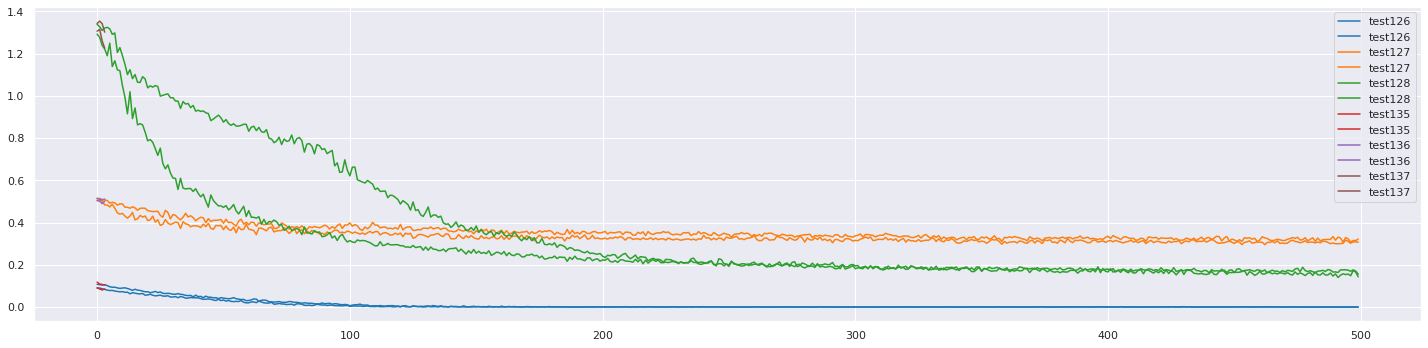

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')#, sharey=True)
temps = ['2e-4', '1e-4', '5e-5']
exp_ids = [f'test{n}' for n in [126, 127, 128, 135, 136, 137]] # ['lowpol_4kb_temp1e-4', '4kb_lowpol_10seq', '4kb_lowpol_10seq_randomflanks', 'test125', '4kb_lowpol_10seq_selfflank'][2:] #
# exp_ids = exp_ids[::-1]
exp_labels = exp_ids # ['stride128', 'stride64', 'stride32', 'stride16'] #
for exp_id, exp_lab, color in zip(exp_ids, exp_labels, colors):
    # if int(exp_id[4:]) in [94, 95]:
    #     continue
    # with open(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_id}/config.txt') as f:
    #     print(''.join(f.readlines()))
    energies = energy_parser(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_id}/energy.txt')
    print(energies.shape)
    ax.plot(energies[:2, :, 0].T, label=exp_lab, color=color)
ax.legend()
# ax.set_xlim(470, 500)
# ax.set_ylim((-0.001, 2))

(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)


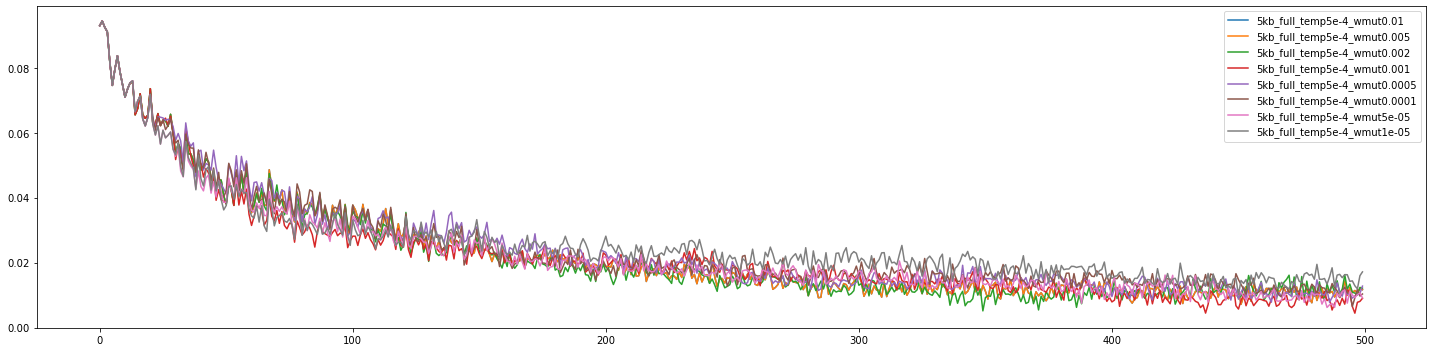

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')#, sharey=True)
exp_ids = [f'test{n}' for n in range(49, 57)]
wmuts = [0.01, 0.005, 0.002, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
exp_labels = [f'5kb_full_temp5e-4_wmut{w}' for w in wmuts]
for exp_id, exp_lab, color in zip(exp_ids, exp_labels, colors):
    energies = energy_parser(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_id}/energy.txt')
    print(energies.shape)
    ax.plot(energies[:1, :, 0].T, label=exp_lab, color=color)
ax.legend()

Probabilities

(2, 12000)


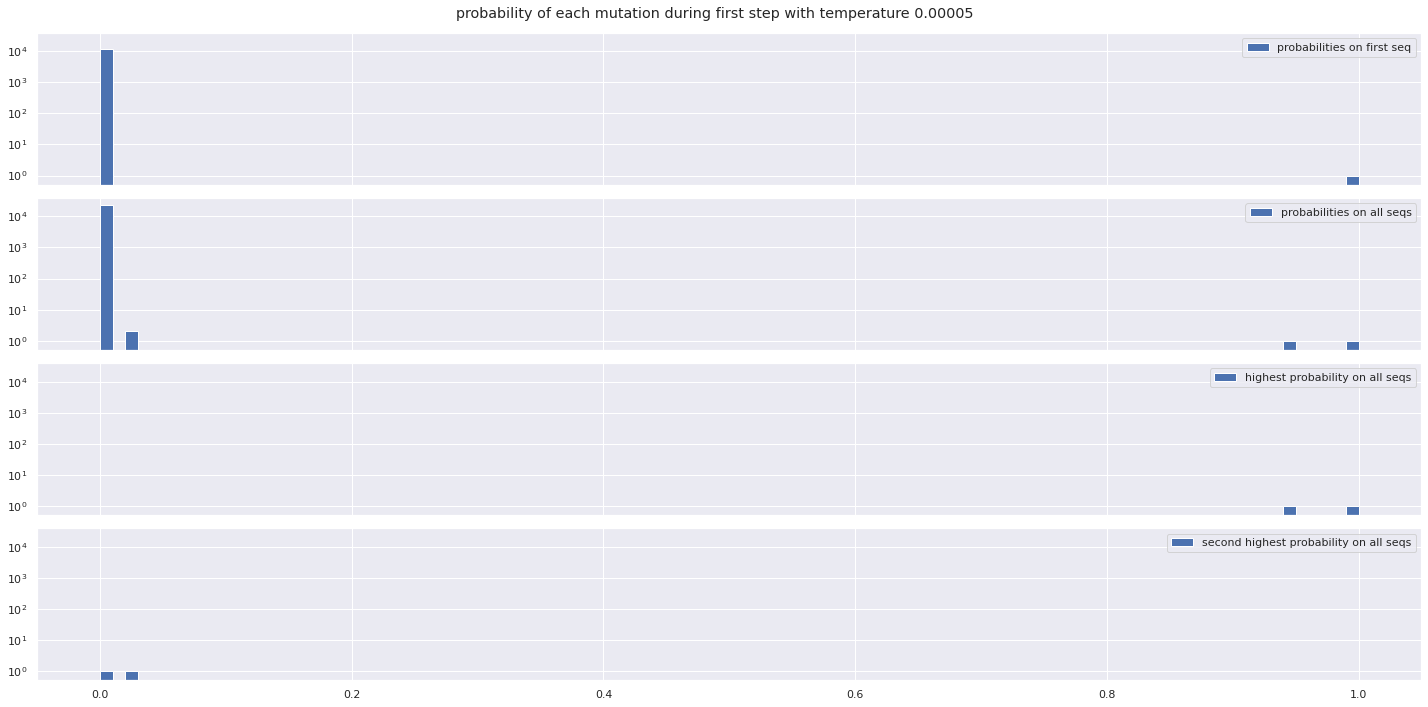

In [67]:
exp_name = 'test135' # '4kb_lowpol_10seq_selfflank'
step = 0
probs = np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/probs/prob_step{step}.npy')
print(probs.shape)
probs = np.sort(probs, axis=1)
fig, axes = plt.subplots(4, 1, figsize=(20, 10), facecolor='w', layout='tight', sharey=True, sharex=True)
fig.suptitle('probability of each mutation during first step with temperature 0.00005')
axes[0].hist(probs[0], bins=100, range=(0, 1), label='probabilities on first seq')
axes[1].hist(probs.ravel(), bins=100, range=(0, 1), label='probabilities on all seqs')
axes[2].hist(probs[:, -1], bins=100, range=(0, 1), label='highest probability on all seqs')
axes[3].hist(probs[:, -2], bins=100, range=(0, 1), label='second highest probability on all seqs')
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(bottom=5e-1)
    ax.legend()
plt.show()

(array([0, 1]), array([10015,  6884]))
(array([0, 1]), array([10015,  6884]))


<AxesSubplot:>

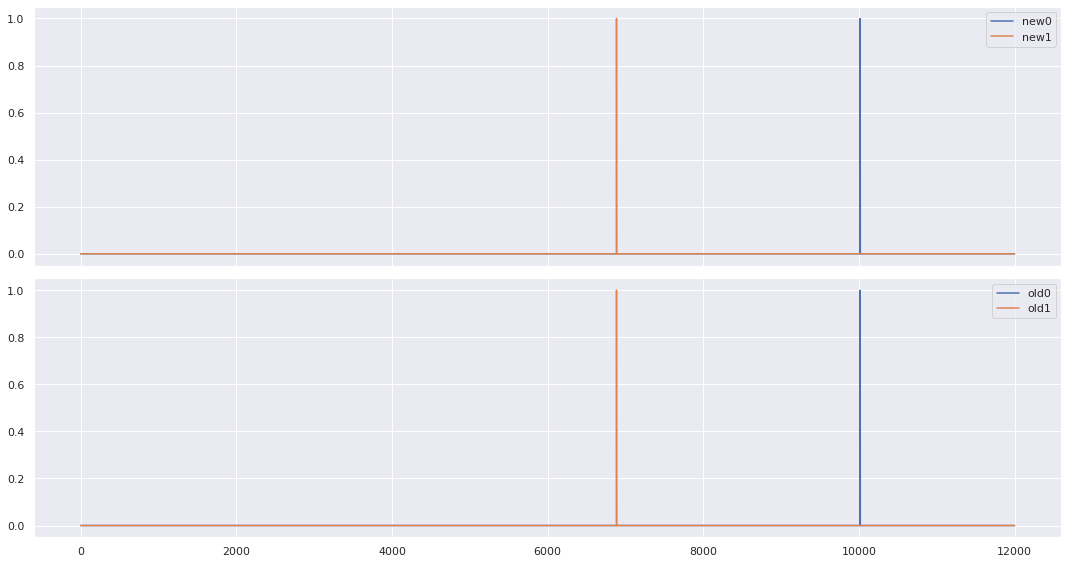

In [76]:
exp_name = 'test137'
step = 2
probs = np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/probs/prob_step{step}.npy')
old_probs = np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/probs/old_prob_step{step}.npy')
print(np.where(probs > 0.01))
print(np.where(old_probs > 0.01))
df = pd.concat(
    [pd.DataFrame(probs.T, columns=['new0', 'new1']),
     pd.DataFrame(old_probs.T, columns=['old0', 'old1'])],
    axis=1)
start = 0
stop = len(df)
# start = 9900
# stop = 10000
fig, axes = plt.subplots(2, 1, figsize=(15, 8), facecolor='w', layout='tight', sharey=True, sharex=True)
df.loc[start:stop, :'new1'].plot(ax=axes[0])
df.loc[start:stop, 'old0':].plot(ax=axes[1])
# plt.yscale('log')

In [8]:
# exp_name = 'lowpol_4kb_temp1e-4'
energies = energy_parser(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/energy.txt')
probs = []
for step in range(energies.shape[1]):
    probs.append(np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/probs/prob_step{step}.npy'))
probs = np.stack(probs, axis=1)
print(probs.shape)
probs = np.sort(probs, axis=-1)

(10, 500, 12000)


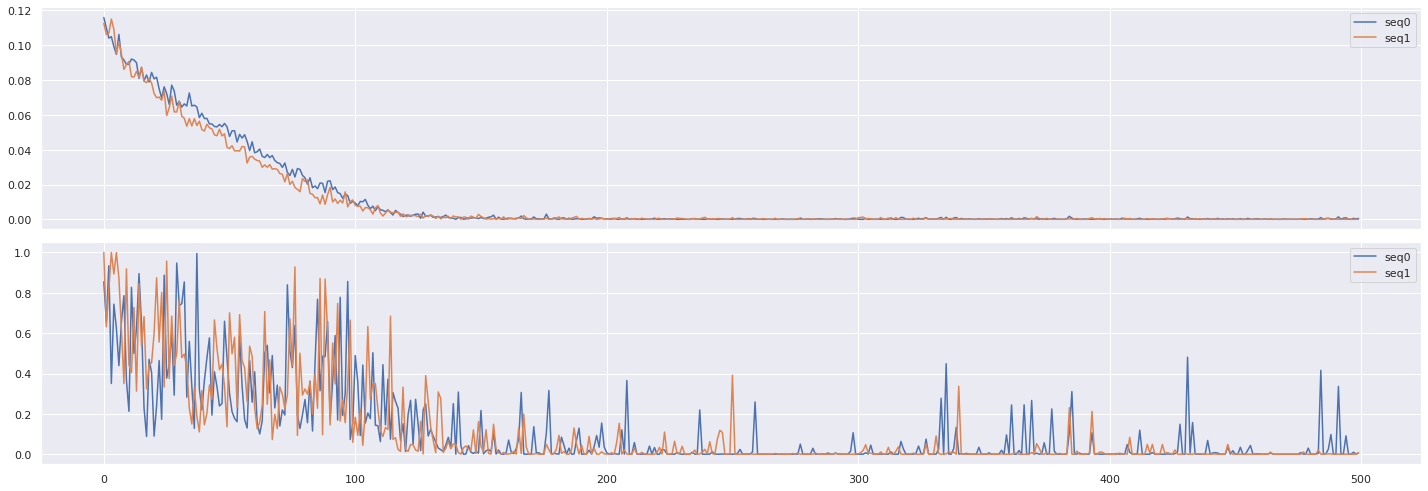

In [9]:
start = 0
stop = 2
fig, axes = plt.subplots(2, 1, figsize=(20, 7), facecolor='w', layout='tight', sharex=True)
axes[0].plot(energies[start:stop, :, 0].T, label=[f'seq{i}' for i in range(start, stop)])
axes[1].plot(probs[start:stop, :, -1].T, label=[f'seq{i}' for i in range(start, stop)])
for ax in axes:
    ax.legend()
plt.show()

Designed sequences

In [11]:
# exp_ids = ['lowpol_4kb_temp1e-4', '4kb_lowpol_10seq', '4kb_lowpol_10seq_randomflanks', 'test125']
exp_name = 'test127' # '4kb_lowpol_10seq_selfflank' # '4kb_peakpol200bp_10seq' # '4kb_lowpol_10seq_randomflanks' # 'lowpol_4kb_temp1e-4' # '4kb_peakpol200bp_10seq' #
# seqs = [np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/start_seqs.npy')]
seqs = [np.load(f'/home/alex/shared_folder/SCerevisiae/generated/test121/designed_seqs/mut_seqs_step499.npy')]
step = 0
while True:
    try:
        seqs.append(np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/mut_seqs_step{step}.npy'))
        step += 1
    except FileNotFoundError:
        break
seqs = np.stack(seqs, axis=1)
print(seqs.shape)

(2, 501, 4000)


In [6]:
myseq = seqs[0, -1]
myseqstr = ''.join(np.array(list('ACGT'))[myseq])
print(myseq[1500:1750])
print(myseqstr[1500:1750])
print(myseqstr[1500:1600])
print(myseqstr[1575:1675])
print(myseqstr[1650:1750])

[1 3 3 1 0 3 1 3 1 0 1 0 3 2 1 0 2 1 3 0 3 2 1 2 2 3 2 3 2 0 0 0 0 0 3 0 0
 3 1 1 2 2 1 0 3 0 1 0 2 2 1 1 0 2 2 1 2 0 0 3 3 0 0 3 3 3 1 0 0 2 1 2 0 3
 0 3 3 3 3 3 3 0 0 3 3 3 3 3 3 0 1 3 1 2 2 3 3 2 0 1 2 2 3 0 2 3 3 1 2 1 0
 2 0 0 2 1 2 2 1 2 2 0 2 3 1 3 2 3 1 0 2 3 3 3 3 3 3 3 1 3 3 3 1 2 1 1 0 2
 1 1 0 0 1 3 3 2 0 0 0 0 3 3 3 3 3 3 3 3 1 2 1 0 1 2 0 0 0 2 3 2 0 0 0 0 0
 0 0 0 0 3 2 2 0 0 0 2 0 3 0 0 2 2 0 3 0 1 0 0 0 3 3 3 0 3 1 3 3 2 3 3 2 2
 0 3 0 0 3 3 2 0 0 0 1 3 0 3 3 3 0 1 3 0 0 1 1 3 1 0 3 1]
CTTCATCTCACATGCAGCTATGCGGTGTGAAAAATAATCCGGCATACAGGCCAGGCGAATTAATTTCAAGCGATATTTTTTAATTTTTTACTCGGTTGACGGTAGTTCGCAGAAGCGGCGGAGTCTGTCAGTTTTTTTCTTTCGCCAGCCAACTTGAAAATTTTTTTTCGCACGAAAGTGAAAAAAAAATGGAAAGATAAGGATACAAATTTATCTTGTTGGATAATTGAAACTATTTACTAACCTCATC
CTTCATCTCACATGCAGCTATGCGGTGTGAAAAATAATCCGGCATACAGGCCAGGCGAATTAATTTCAAGCGATATTTTTTAATTTTTTACTCGGTTGAC
TTTTTTAATTTTTTACTCGGTTGACGGTAGTTCGCAGAAGCGGCGGAGTCTGTCAGTTTTTTTCTTTCGCCAGCCAACTTGAAAATTTTTTTTCGCACGA
AACTTGAAAATTTTTTTTCGCACGAAAGTGAAAAAAAAA

In [8]:
print(myseqstr[1666:1679])

TTCGCACGAAAGT


In [258]:
import re
seqlet = myseqstr[1500:1750]
cigar = '5M6I6M2I7M6I1M3I2M2I4M1I4M1D3M3I3M3I11M2I6M1I3M15I3M1I3M1I20M2I8M25I15M3I10M1D3M3I2M4I5M3I4M1D7M1I3M11I5M1I8M'
splits = re.split('(M|D|I)', cigar)[:-1]
seqpos = 0
query = ''
ref = ''
left = 0
total = 0
for i in range(0, len(splits), 2):
    length, mode = splits[i:i+2]
    length = int(length)
    if mode == 'M':
        ref += 'X'*length
        query += seqlet[seqpos:seqpos+length]
        seqpos += length
    elif mode == 'D':
        ref += 'X'*length
        query += '-'*length
    elif mode == 'I':
        ref += '-'*length
        query += seqlet[seqpos:seqpos+length]
        seqpos += length
    else:
        left += length
        print(mode, 'skipped')
    total += length
print(ref)
print(query)

XXXXX------XXXXXX--XXXXXXX------X---XX--XXXX-XXXXXXXX---XXX---XXXXXXXXXXX--XXXXXX-XXX---------------XXX-XXX-XXXXXXXXXXXXXXXXXXXX--XXXXXXXX-------------------------XXXXXXXXXXXXXXX---XXXXXXXXXXXXXX---XX----XXXXX---XXXXXXXXXXXX-XXX-----------XXXXX-XXXXXXXX
CTTCATCTCACATGCAGCTATGCGGTGTGAAAAATAATCCGGCATACAG-GCCAGGCGAATTAATTTCAAGCGATATTTTTTAATTTTTTACTCGGTTGACGGTAGTTCGCAGAAGCGGCGGAGTCTGTCAGTTTTTTTCTTTCGCCAGCCAACTTGAAAATTTTTTTTCGCACGAAAGTGAAAAAAAAAT-GGAAAGATAAGGATACAAATTTAT-CTTGTTGGATAATTGAAACTATTTACTAACCTCATC


In [242]:
# utils.write_fasta({'full': myseqstr, "1500-1750": myseqstr[1500:1750]}, '/home/alex/shared_folder/SCerevisiae/results/generated/test101/4kb_tss_like.fa')

In [ ]:
seq_idx = 0
# print(np.where(seqs[seq_idx, 0] != seqs[seq_idx, -1])[0])
fig, ax = plt.subplots(1, 1, figsize=(20, 3), facecolor='w', layout='tight')
ax.bar(np.where(seqs[seq_idx, 0] != seqs[seq_idx, -1])[0], height=1, width=1.3, color='k')
# ax.set_xlim(0, seqs.shape[-1])

In [ ]:
# start_seqs = np.load(f'/home/alex/shared_folder/SCerevisiae/generated/test9/start_seqs.npy')
# np.save('/home/alex/shared_folder/SCerevisiae/generated/test9/start_seqs_first1.npy', start_seqs[:1])

In [31]:
with np.load('/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco_random1kbflanks_ACGTidx.npz') as f:
    flank_left = f['left']
    flank_right = f['right']

Repredicting

In [12]:
with np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/target.npz') as f:
    target = f['forward']
    target_rev = f['reverse']

In [27]:
target = np.zeros(4000)
target_rev = target

In [63]:
preds, indices = get_profile_chunk(seqs, model_pol, 2048, head_interval=128, middle=True, return_index=True)
preds_rev, indices_rev = get_profile_chunk(seqs, model_pol, 2048, head_interval=128, middle=True, return_index=True, reverse=True)
# preds, indices = get_profile_chunk(seqs, model_nuc, 2001, return_index=True)
# preds_rev, indices_rev = get_profile_chunk(seqs, model_nuc, 2001, return_index=True, reverse=True)
# preds = get_profile_mid1(seqs, model_rna, 2001, one_hot_converter=lambda x: np_idx_to_one_hot(x, order='ATGC', extradims=-1), return_index=True)
# preds_rev = get_profile_mid1(seqs, model_rna, 2001, one_hot_converter=lambda x: np_idx_to_one_hot(x, order='ATGC', extradims=-1), return_index=True, reverse=True)
loss = rmse(target[indices], preds)
loss_rev = rmse(target_rev[indices_rev], preds_rev)
gc_energy = GC_energy(seqs, 0.3834)

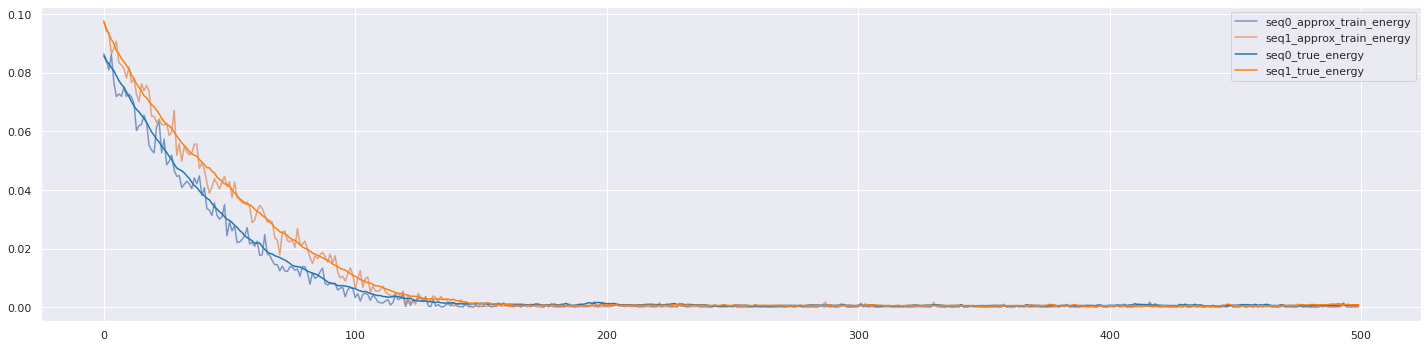

In [64]:
energies = energy_parser(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/energy.txt')
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')
ax.plot(energies[:, :, 0].T, label=[f'seq{i}_approx_train_energy' for i in range(2)], alpha=0.7)
for idx in range(len(seqs)):
    ax.plot(gc_energy[idx, 1:] + loss[idx, 1:] + loss_rev[idx, 1:], label=f'seq{idx}_true_energy', color=colors[idx])
ax.legend()
filename = utils.safe_filename(f'/home/alex/shared_folder/SCerevisiae/results/generated/{exp_name}/energy_during_optimization.png')
fig.savefig(filename, bbox_inches='tight')

In [142]:
exp_ids = ['lowpol_4kb_temp1e-4', '4kb_lowpol_10seq', '4kb_lowpol_10seq_randomflanks', 'test125']
seqs = []
for exp_name in exp_ids:
    seqs.append(np.array([np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/start_seqs.npy'),
                          np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/mut_seqs_step499.npy')]))
seqs = np.concatenate(seqs, axis=1)
print(seqs.shape)

(2, 24, 4000)


In [211]:
seqsstr = np.array(list('ACGT'))[seqs]
# utils.write_fasta({f'seq{i}': ''.join(seqsstr[1, seq_idx]) for i, seq_idx in enumerate(range(12, 24))}, '/home/alex/shared_folder/SCerevisiae/generated/Tosend20231106/optimized_seqs.fa')


In [13]:
steps = np.array([0, 500])
to_predict = seqs[:, steps]#.reshape(5, 2, -1)#
print(to_predict.shape)
flanks = 'self'
preds_pol, indices_pol = get_profile_chunk(to_predict, model_pol, 2048, 128, middle=True, return_index=True, flanks=flanks)
preds_pol_rev, indices_pol_rev = get_profile_chunk(to_predict, model_pol, 2048, 128, reverse=True, middle=True, return_index=True, flanks=flanks)
preds_nuc, indices_nuc = get_profile_chunk(to_predict, model_nuc, 2001, return_index=True, flanks=flanks)
preds_nuc_rev, indices_nuc_rev = get_profile_chunk(to_predict, model_nuc, 2001, reverse=True, return_index=True, flanks=flanks)
preds_rna, indices_rna = get_profile_chunk(to_predict, model_rna, 2001, one_hot_converter=lambda x: utils.np_idx_to_one_hot(x, order='ATGC', extradims=-1), return_index=True, flanks=flanks)
preds_rna_rev, indices_rna_rev = get_profile_chunk(to_predict, model_rna, 2001, reverse=True, one_hot_converter=lambda x: utils.np_idx_to_one_hot(x, order='ATGC', extradims=-1), return_index=True, flanks=flanks)

(2, 2, 4000)


/home/alex/shared_folder/SCerevisiae/results/generated/test127/all_profiles_start_end.png exists, changing filename to /home/alex/shared_folder/SCerevisiae/results/generated/test127/all_profiles_start_end(2).png


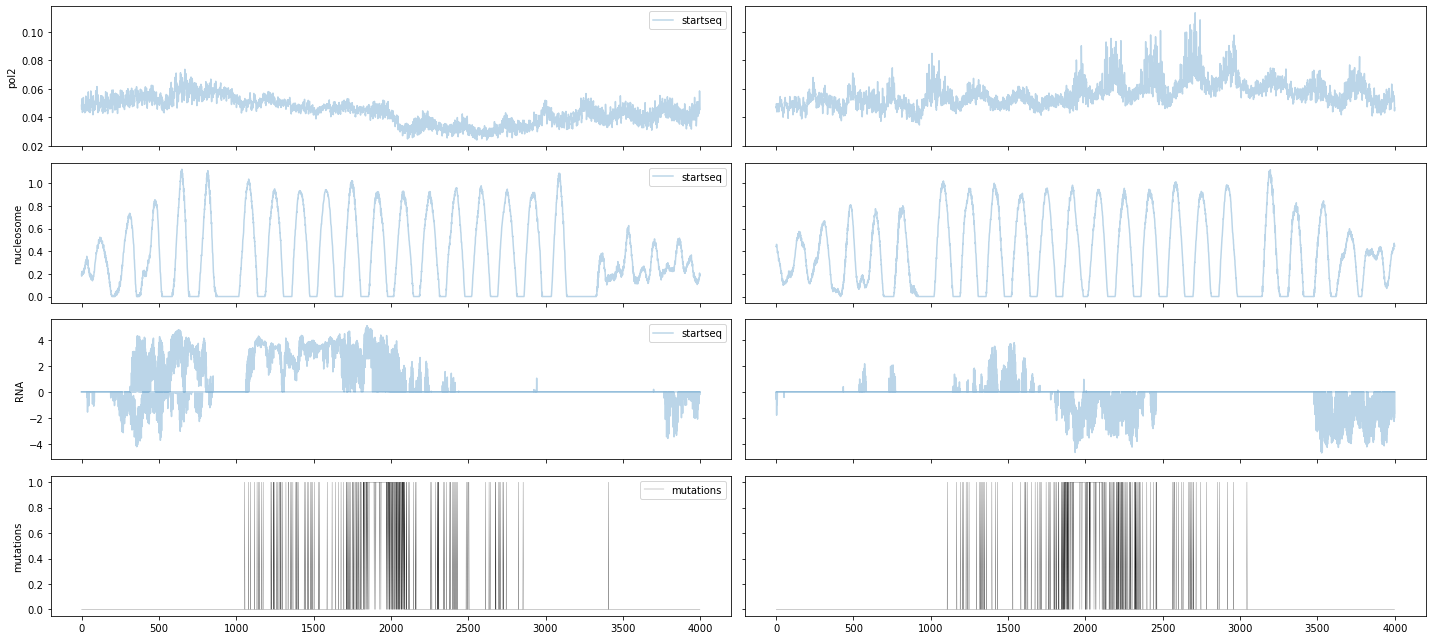

In [15]:
start = 0
stop = 2
n_seqs = stop - start
length = to_predict.shape[-1]
targ_row = 0
# Merge forward and reverse
merge_pol = utils.mean_on_index((indices_pol, preds_pol), (indices_pol_rev, preds_pol_rev), length=length)
merge_nuc = utils.mean_on_index((indices_nuc, preds_nuc), (indices_nuc_rev, preds_nuc_rev), length=length)
fig, axes = plt.subplots(4, n_seqs, figsize=(20, 9), facecolor='w', layout='tight', sharex=True, sharey='row')
# targ_ax.plot(-target_rev, color='k')
for seq_idx in range(start, stop):
    ax_col = seq_idx - start
    # axes[targ_row, ax_col].plot(target, color='k', label='target')
    for i, (step, color, alpha, label) in enumerate(zip(steps, colors[::3], [0.3, 0.8], ['startseq', 'optimized'])):
        axes[0, ax_col].plot(merge_pol[seq_idx, i, :], color=color, label=label, alpha=alpha)
        axes[1, ax_col].plot(merge_nuc[seq_idx, i, :], color=color, label=label, alpha=alpha)
        axes[2, ax_col].plot(indices_rna, preds_rna[seq_idx, i, :], color=color, label=label, alpha=alpha)
        axes[2, ax_col].plot(indices_rna_rev, -preds_rna_rev[seq_idx, i, :], color=color, alpha=alpha)
        break
    # axes[3, ax_col].bar(np.where(seqs[seq_idx, steps[0]] != seqs[seq_idx, steps[-1]])[0], height=1, width=1, color='k', label='mutations')
    axes[3, ax_col].plot(seqs[seq_idx, steps[0]] != seqs[seq_idx, steps[-1]], linewidth=0.2, color='k', label='mutations')
for ax, ylab in zip(axes[:, 0], ['pol2', 'nucleosome', 'RNA', 'mutations']):
    ax.legend()
    ax.set_ylabel(ylab)
filename = utils.safe_filename(f'/home/alex/shared_folder/SCerevisiae/results/generated/{exp_name}/all_profiles_start_end.png')
fig.savefig(filename, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(18, 12), facecolor='w')
subfigs = fig.subfigures(3, 1)
axes = [subfig.subplots(3, 4, sharex=True, sharey='row') for subfig in subfigs]
axes = np.array(axes)

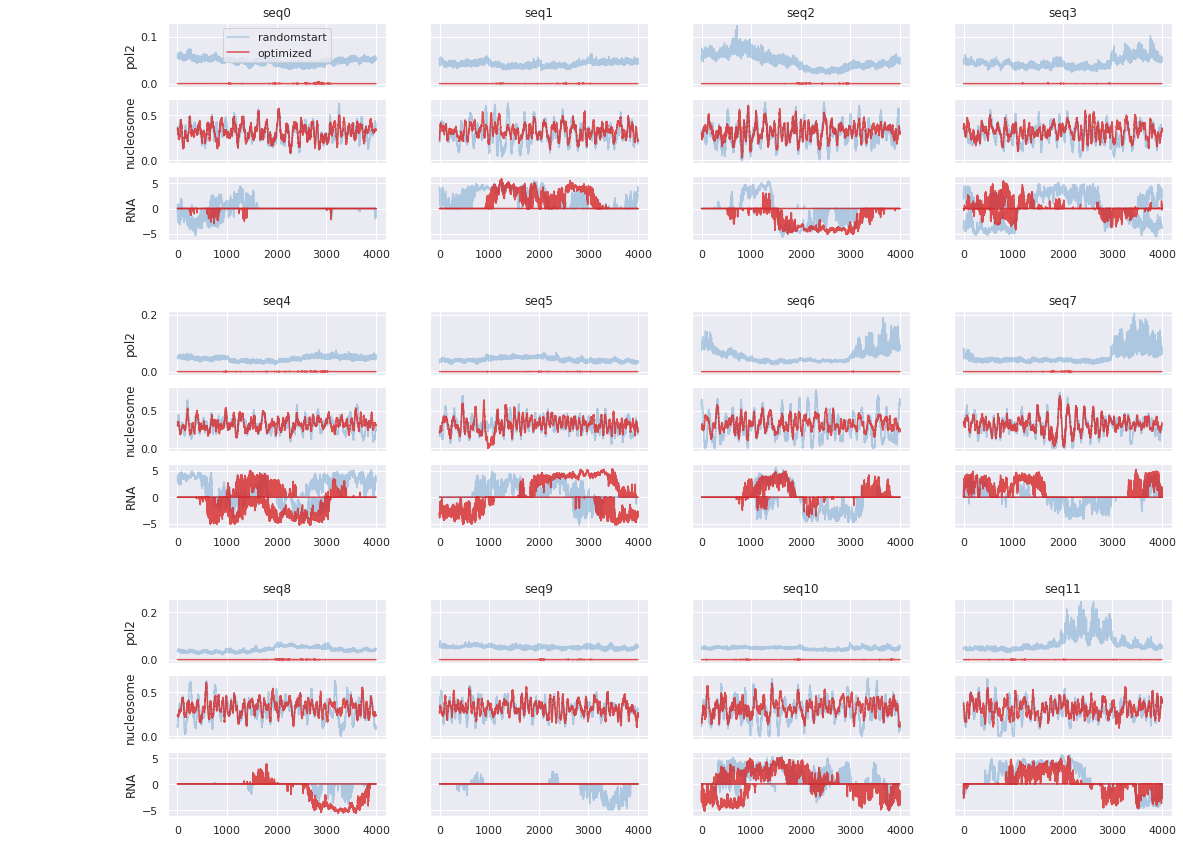

In [209]:
seq_idxes = np.arange(12, 24)
length = to_predict.shape[-1]
# Merge forward and reverse
merge_pol = utils.mean_on_index((indices_pol, preds_pol), (indices_pol_rev, preds_pol_rev), length=length)
merge_nuc = utils.mean_on_index((indices_nuc, preds_nuc), (indices_nuc_rev, preds_nuc_rev), length=length)
fig = plt.figure(figsize=(18, 12), facecolor='w')
subfigs = fig.subfigures(3, 1)
axes = [subfig.subplots(3, 4, sharex=True, sharey='row') for subfig in subfigs]
axes = np.array(axes)
# targ_ax.plot(-target_rev, color='k')
for j, (seq_idx, title) in enumerate(zip(seq_idxes, titles)):
    subfig_row, ax_col = divmod(j, 4)
    axes[subfig_row, 0, ax_col].set_title(f'seq{j}')
    for i, (color, lab, alpha) in enumerate(zip(colors[::3], ['randomstart', 'optimized'], [0.3, 0.8])):
        axes[subfig_row, 0, ax_col].plot(merge_pol[i, seq_idx, :], color=color, label=lab, alpha=alpha)
        axes[subfig_row, 1, ax_col].plot(merge_nuc[i, seq_idx, :], color=color, label=lab, alpha=alpha)
        axes[subfig_row, 2, ax_col].plot(indices_rna, preds_rna[i, seq_idx, :], color=color, label=lab, alpha=alpha)
        axes[subfig_row, 2, ax_col].plot(indices_rna_rev, -preds_rna_rev[i, seq_idx, :], color=color, alpha=alpha)
    # axes[3, ax_col].bar(np.where(seqs[0, seq_idx] != seqs[1, seq_idx])[0], height=1, width=1.3, color='k', label='mutations')
for ax, ylab in zip(axes[:, :, 0].flatten(), ['pol2', 'nucleosome', 'RNA']*3):
    ax.set_ylabel(ylab)
axes[0, 0, 0].legend()

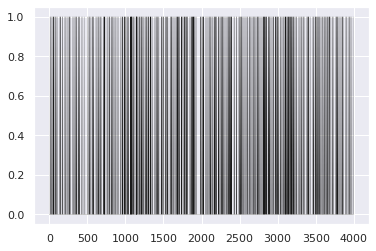

In [60]:
plt.plot(seqs[0, steps[0]] != seqs[0, steps[-1]], color='k', linewidth=0.2)

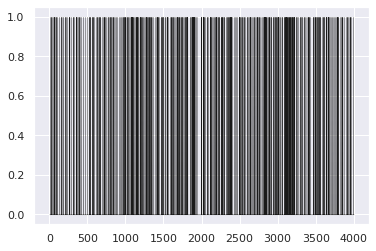

In [59]:
mutations = np.where(seqs[0, steps[0]] != seqs[0, steps[-1]])[0]
plt.fill_between(np.arange(4000), seqs[0, steps[0]] != seqs[0, steps[-1]], color='k', linewidth=0.2)

<BarContainer object of 492 artists>

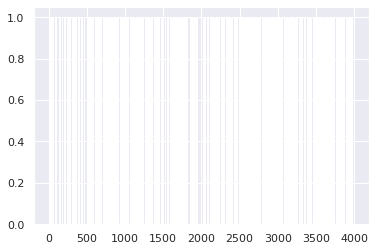

In [55]:
plt.bar(np.where(seqs[0, steps[0]] != seqs[0, steps[-1]])[0], height=1, width=1, color='k', label='mutations')

Testing predict functions

In [10]:
n = 10
l = 4000
freq_kmers = pd.read_csv('/home/alex/shared_folder/SCerevisiae/genome/W303/W303_3mer_freq.csv', index_col=[0, 1, 2])
np.random.seed(0)
seqs = utils.random_sequences(n, l, freq_kmers.iloc[:, 0], out='idx')
print(seqs.shape)
print(seqs)

(10, 4000)
[[2 0 3 ... 0 1 0]
 [3 0 1 ... 1 3 0]
 [2 2 0 ... 3 3 2]
 ...
 [3 2 3 ... 0 3 3]
 [3 3 3 ... 1 1 2]
 [1 1 0 ... 2 3 3]]


In [ ]:
to_predict = seqs#[:, ::100]
print(to_predict.shape)
preds = get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=None)
preds_rev = get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=None, reverse=True)
preds_flanks = []
preds_flanks_rev = []
for i in range(len(flank_left)):
    flanks=(flank_left[i], flank_right[i])
    preds_flanks.append(get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=flanks))
    preds_flanks_rev.append(get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=flanks, reverse=True))
preds_flanks = np.array(preds_flanks)
preds_flanks_rev = np.array(preds_flanks_rev)
print(preds.shape, preds_rev.shape)
print(preds_flanks.shape, preds_flanks_rev.shape)

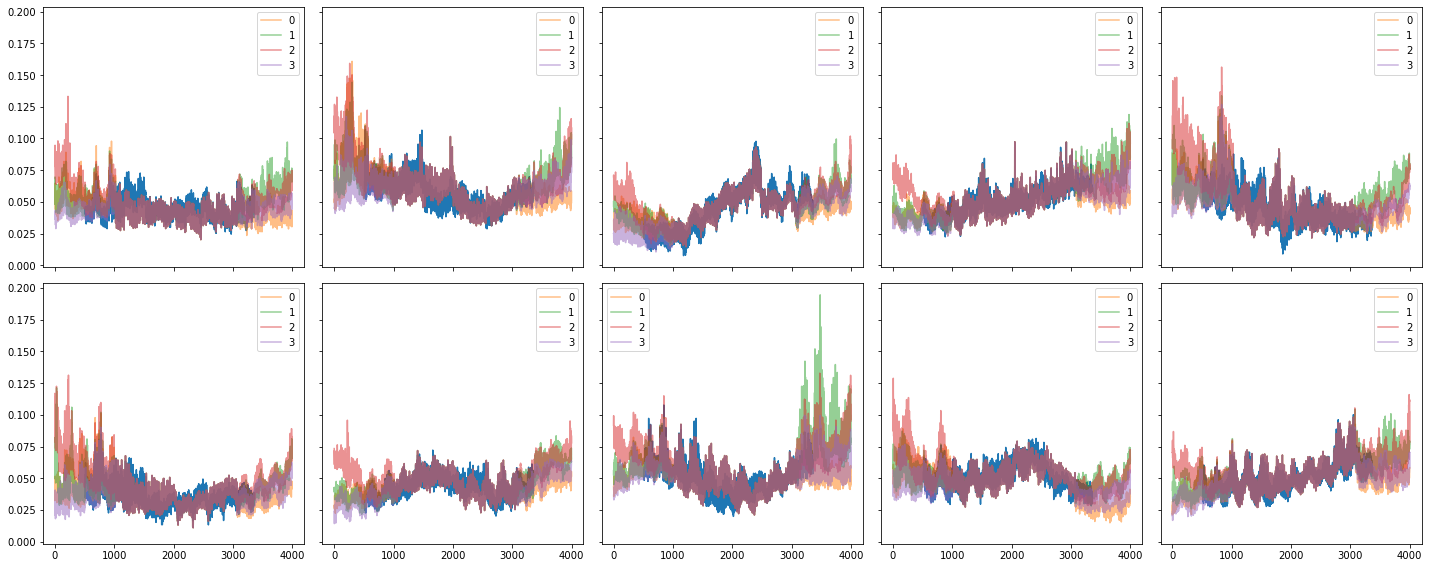

In [41]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8), facecolor='w', layout='tight', sharex=True, sharey=True)
start = 0
stop = 4
for i, ax in enumerate(axes.flatten()):
    ax.plot(np.arange(512, 512+preds.shape[-1]), preds[i])
    # ax.plot(np.arange(512+127, 512+127+preds.shape[-1]), preds_rev[i])
    ax.plot(preds_flanks[start:stop, i].T, label=[i for i in range(start, stop)], alpha=0.5)
    # ax.plot(preds_flanks_rev[start:stop, i].T, alpha=0.5)
    ax.legend()

# Saliency

In [4]:
def get_gradients(model, one_hots, batch_size=1024, predict=False, head_start=0, n_heads=1):
    grads = np.empty(one_hots.shape, dtype='float32')
    n_batches = int(np.ceil((len(one_hots) / batch_size)))
    preds = None
    for i in range(n_batches):
        batch_start, batch_stop = i*batch_size, (i+1)*batch_size
        X = tf.Variable(one_hots[batch_start:batch_stop], dtype=tf.float32)
        with tf.GradientTape() as tape:
            Y = model(X, training=False)[:, head_start:head_start+n_heads]
        grads[batch_start:batch_stop] = np.array(tape.gradient(Y, X))
        if predict:
            Y = np.array(Y).squeeze()
            if i == 0:
                preds = np.empty((len(one_hots),) + Y.shape[1:],
                                 dtype='float32')
            preds[batch_start:batch_stop] = Y
    if predict:
        return grads.squeeze(), preds
    else:
        return grads.squeeze()

In [7]:
with np.load('/home/alex/shared_folder/SCerevisiae/results/model_myco_pol_17/preds_mid_on_W303_Mmmyco.npz') as f:
    preds_pol = {k: f[k] for k in f.keys() if k[:3] == 'chr'}

In [3]:
with np.load('/home/alex/shared_folder/SCerevisiae/data/GSE217022/labels_myco_pol_ratio.npz') as f:
    labels_pol = {k: f[k] for k in f.keys() if k[:3] == 'chr'}

In [32]:
with np.load('/home/alex/shared_folder/SCerevisiae/data/labels_myco_nuc.npz') as f:
    labels_nuc = {k: f[k] for k in f.keys() if k[:3] == 'chr'}

In [4]:
def autocorr(signal, smooth_size=None):
    centered_signal = signal - np.mean(signal)
    corrs = scipy.signal.correlate(centered_signal, centered_signal, mode='full')
    lags = scipy.signal.correlation_lags(signal.size, signal.size, mode="full")
    if smooth_size is not None:
        corrs = utils.smooth(corrs, smooth_size)
    corrs /= corrs[lags == 0]
    return lags, corrs

In [5]:
# with np.load('/home/alex/shared_folder/SCerevisiae/data/labels_pneu_nuc.npz') as f:
#     labels = {k: f[k] for k in f.keys() if k not in ['Mito', 'Mpneumo']}
# with np.load('/home/alex/shared_folder/SCerevisiae/data/labels_myco_nuc.npz') as f:
#     labels.update({k: f[k] for k in f.keys()})
# with np.load('/home/alex/shared_folder/SCerevisiae/data/labels_pneu_nuc.npz') as f:
#     labels['Mpneumo'] = f['Mpneumo']
# with np.load('/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/preds_on_S288c_Mpneumo.npz') as f:
#     preds = {k: f[k] for k in f.keys() if k[-4:] != '_rev' and k not in ['Mito', 'Mpneumo']}
# with np.load('/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/preds_on_W303_Mmmyco.npz') as f:
#     preds.update({k: f[k] for k in f.keys() if k[-4:] != '_rev'})
# with np.load('/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/preds_on_S288c_Mpneumo.npz') as f:
#     preds['Mpneumo'] = f['Mpneumo']

# with np.load('/home/alex/shared_folder/SCerevisiae/data/labels_pneu_nuc.npz') as f:
#     labels = {k: f[k] for k in f.keys() if k not in ['Mito']}
# with np.load('/home/alex/shared_folder/SCerevisiae/data/labels_myco_nuc.npz') as f:
#     labels['Mmmyco'] = f['Mmmyco']
# with np.load('/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/preds_on_S288c_Mpneumo.npz') as f:
#     preds = {k: f[k] for k in f.keys() if k[-4:] != '_rev' and k not in ['Mito']}
# with np.load('/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/preds_on_W303_Mmmyco.npz') as f:
#     preds['Mmmyco'] = f['Mmmyco']

with np.load('/home/alex/shared_folder/SCerevisiae/data/labels_myco_nuc.npz') as f:
    labels = {k: f[k] for k in f.keys()}
with np.load('/home/alex/shared_folder/SCerevisiae/data/labels_pneu_nuc.npz') as f:
    labels['Mpneumo'] = f['Mpneumo']
with np.load('/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/preds_on_W303_Mmmyco.npz') as f:
    preds = {k: f[k] for k in f.keys() if k[-4:] != '_rev'}
with np.load('/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/preds_on_S288c_Mpneumo.npz') as f:
    preds['Mpneumo'] = f['Mpneumo']
print(list(labels.keys()))
print(list(preds.keys()))
label_corrs = {}
preds_corrs = {}
for chr_id, signal in labels.items():
    label_corrs[chr_id] = autocorr(signal)
    preds_corrs[chr_id] = autocorr(preds[chr_id], smooth_size=4)

['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX', 'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'Mmmyco', 'Mpneumo']
['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX', 'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'Mmmyco', 'Mpneumo']


(-1.0, 400.0)

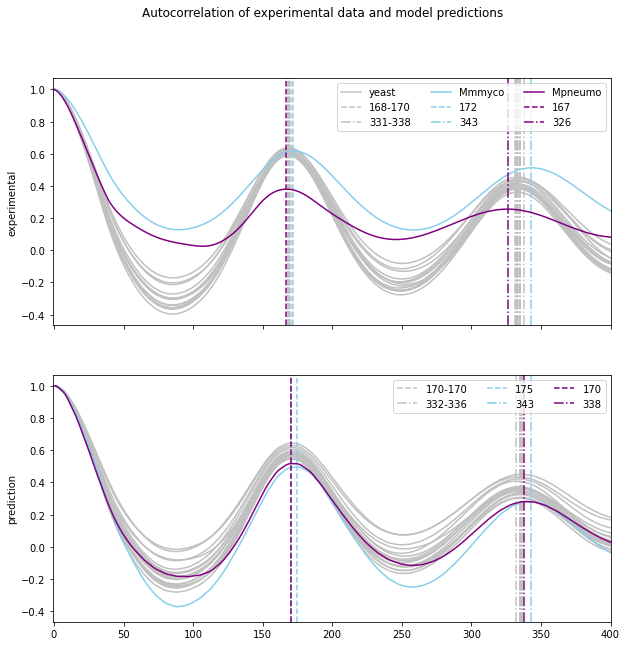

In [7]:
def none_func(x): return None

def lastyeastchr_func(x):
    if x == autocorr1:
        return f'{min1}-{max1}'
    elif x == autocorr2:
        return f'{min2}-{max2}'
    else:
        return 'yeast'

yeast_color = 'silver' # 'gray'
myco_color = 'skyblue'
pneu_color = 'purple' # 'darkmagenta'

fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(10, 10), facecolor='w')
fig.suptitle('Autocorrelation of experimental data and model predictions')

autocorrs_yeast = []
for chr_id, (lags, corrs) in label_corrs.items():
    autocorr1 = 100 + np.argmax(corrs[(lags >= 100) & (lags < 250)])
    autocorr2 = 250 + np.argmax(corrs[(lags >= 250) & (lags < 450)])
    lab_func = str
    if chr_id == 'Mmmyco':
        color = myco_color
    elif chr_id == 'Mpneumo':
        color = pneu_color
    else:
        color = yeast_color
        autocorrs_yeast.append([autocorr1, autocorr2])
        lab_func = none_func
        if chr_id[-3:] == 'XVI':
            autocorrs_yeast = np.array(autocorrs_yeast)
            min1, min2 = np.min(autocorrs_yeast, axis=0)
            max1, max2 = np.max(autocorrs_yeast, axis=0)
            lab_func = lastyeastchr_func
    axes[0].plot(lags, corrs, color=color, label=lab_func(chr_id))
    axes[0].axvline(autocorr1, linestyle='--', color=color, label=lab_func(autocorr1))
    axes[0].axvline(autocorr2, linestyle='-.', color=color, label=lab_func(autocorr2))
axes[0].legend(loc='upper right', ncol=3)

autocorrs_yeast = []
for chr_id, (lags, corrs) in preds_corrs.items():
    autocorr1 = 100 + np.argmax(corrs[(lags >= 100) & (lags < 250)])
    autocorr2 = 250 + np.argmax(corrs[(lags >= 250) & (lags < 450)])
    lab_func = str
    if chr_id == 'Mmmyco':
        color = myco_color
    elif chr_id == 'Mpneumo':
        color = pneu_color
    else:
        color = yeast_color
        autocorrs_yeast.append([autocorr1, autocorr2])
        lab_func = none_func
        if chr_id[-3:] == 'XVI':
            autocorrs_yeast = np.array(autocorrs_yeast)
            min1, min2 = np.min(autocorrs_yeast, axis=0)
            max1, max2 = np.max(autocorrs_yeast, axis=0)
            lab_func = lastyeastchr_func
    axes[1].plot(lags, corrs, color=color)
    axes[1].axvline(autocorr1, linestyle='--', color=color, label=lab_func(autocorr1))
    axes[1].axvline(autocorr2, linestyle='-.', color=color, label=lab_func(autocorr2))
axes[1].legend(loc='upper right', ncol=3)

axes[0].set_ylabel('experimental')
axes[1].set_ylabel('prediction')
axes[0].set_xlim((-1, 400))

In [111]:
len(np.unique(labels['Mmmyco']))

370

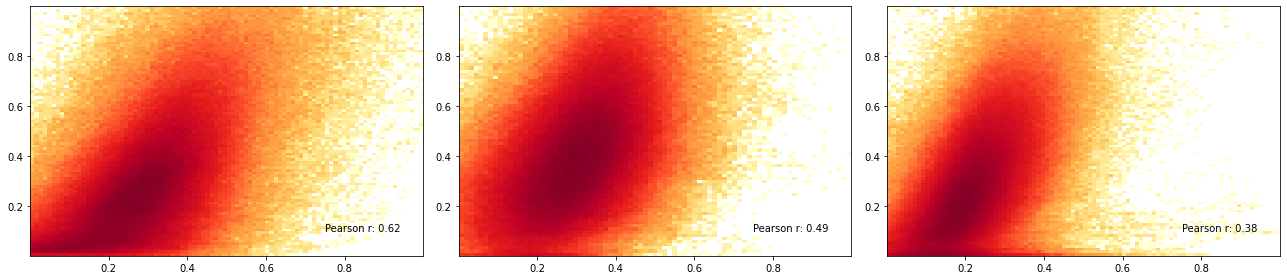

In [205]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4), facecolor='w', layout='tight')
axes[0].hist2d(preds['chrXVI'], labels['chrXVI'], bins=92, range=[(0.001, 0.999), (0.001, 0.999)], norm=mpl.colors.LogNorm(),
               cmap='YlOrRd'
)
axes[1].hist2d(preds['Mpneumo'], labels['Mpneumo'], bins=79, range=[(0.001, 0.999), (0.001, 0.999)], norm=mpl.colors.LogNorm(),
               cmap='YlOrRd'
        #    cmap=sns.cubehelix_palette(start=1, rot=-.4, dark=.2, as_cmap=True)
        #    cmap=sns.light_palette("purple", as_cmap=True)
)
axes[2].hist2d(preds['Mmmyco'], labels['Mmmyco'], bins=92, range=[(0.001, 0.999), (0.001, 0.999)], norm=mpl.colors.LogNorm(),
               cmap='YlOrRd'
        #    cmap=sns.cubehelix_palette(start=0.3, rot=-.4, dark=.3, as_cmap=True)
        #    cmap=sns.light_palette('blue', as_cmap=True)
)
axes[0].annotate('Pearson r: 0.62', (0.75, 0.1))
axes[1].annotate('Pearson r: 0.49', (0.75, 0.1))
axes[2].annotate('Pearson r: 0.38', (0.75, 0.1))
plt.show()

In [194]:
non0 = (labels['chrXVI'] != 0) #& (preds['chrXVI'] != 0)
print(pearsonr(labels['chrXVI'][non0], preds['chrXVI'][non0]))
non0 = (labels['Mpneumo'] != 0) #& (preds['Mpneumo'] != 0)
print(pearsonr(labels['Mpneumo'][non0], preds['Mpneumo'][non0]))
non0 = (labels['Mmmyco'] != 0) #& (preds['Mmmyco'] != 0)
print(pearsonr(labels['Mmmyco'][non0], preds['Mmmyco'][non0]))

(0.614756092494728, 0.0)
(0.4822133941573928, 0.0)
(0.5587168389988754, 0.0)


In [195]:
print(pearsonr(labels['chrXVI'], preds['chrXVI']), pearsonr(labels['chrXVI'], utils.smooth(preds['chrXVI'], 8)))
print(pearsonr(labels['Mpneumo'], preds['Mpneumo']), pearsonr(labels['Mpneumo'], utils.smooth(preds['Mpneumo'], 8)))
print(pearsonr(labels['Mmmyco'], preds['Mmmyco']), pearsonr(labels['Mmmyco'], utils.smooth(preds['Mmmyco'], 8)))

(0.6214916941910827, 0.0) (0.6259154739755307, 0.0)
(0.49294914088656067, 0.0) (0.4995847124096655, 0.0)
(0.37889390681228363, 0.0) (0.38249857506313706, 0.0)


(0.6113619535586289, 2.5503961012937015e-205)


[]

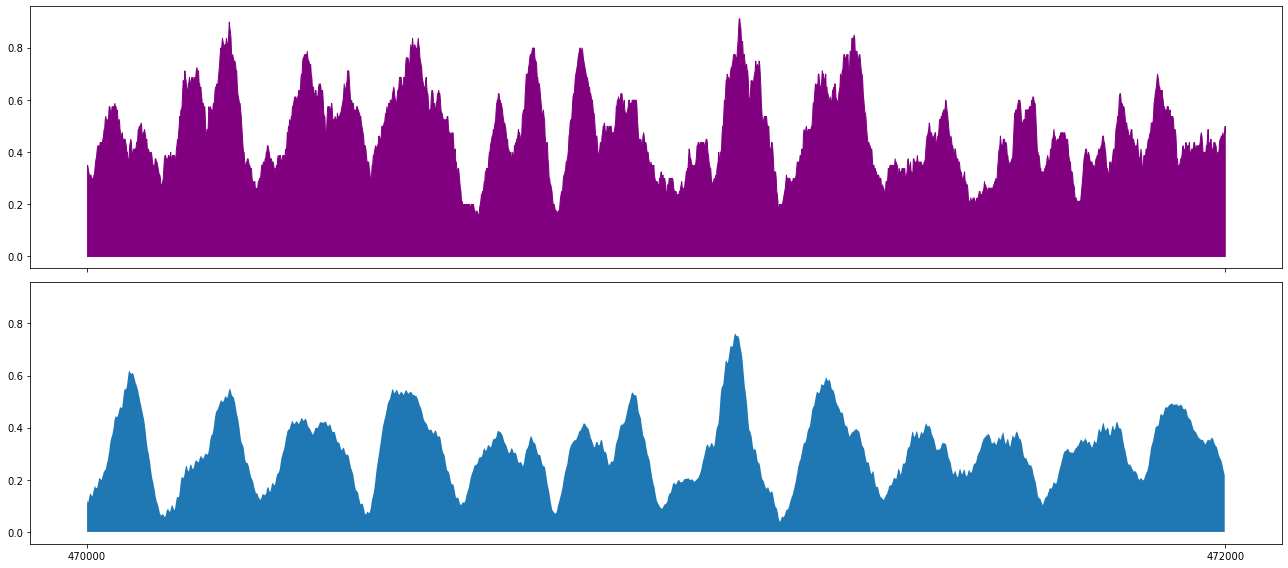

In [247]:
fig, axes = plt.subplots(2, 1, figsize=(18, 8), facecolor='w', layout='tight', sharex='col', sharey=True)
start = 470000
stop = start + 2000 # 424000
axes[0].fill_between(np.arange(start, stop), labels['Mpneumo'][start:stop], color=pneu_color)
axes[1].fill_between(np.arange(start, stop), utils.smooth(preds['Mpneumo'], 4)[start:stop])#, alpha=0.6)
print(pearsonr(labels['Mpneumo'][start:stop], preds['Mpneumo'][start:stop]))
axes[0].set_xticks([start, stop])
axes[0].set_xticklabels([str(start), str(stop)])

(0.802117571199519, 0.0)
(0.6113619535586289, 2.5503961012937015e-205)
(0.7521283533241765, 0.0)


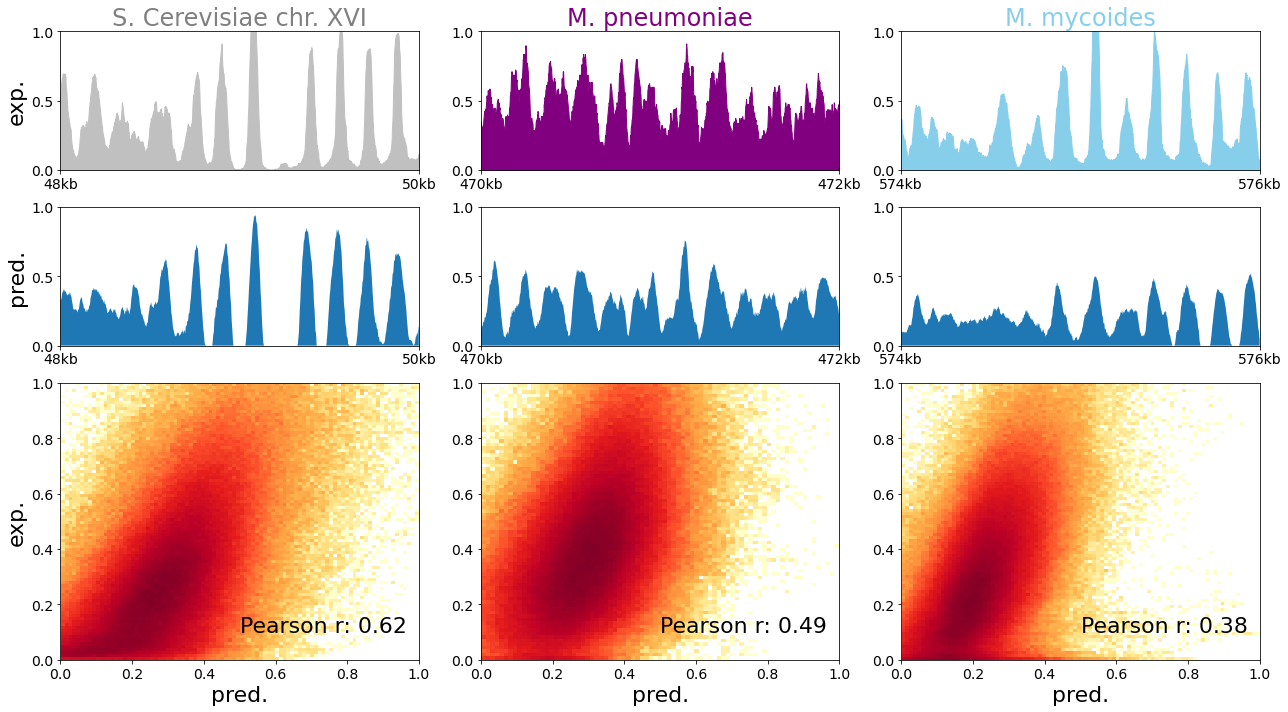

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(18, 10), facecolor='w', layout='tight', gridspec_kw={'height_ratios': [1, 1, 2]})
start = 48000
stop = 50000
axes[0, 0].fill_between(np.arange(start, stop), labels['chrXVI'][start:stop], color=yeast_color)
axes[1, 0].fill_between(np.arange(start, stop), utils.smooth(preds['chrXVI'], 4)[start:stop])
for i in range(2):
    axes[i, 0].set_xticks([start, stop])
    axes[i, 0].set_xticklabels([f'{start//1000}kb', f'{stop//1000}kb'])
    axes[i, 0].set_yticks([0, 0.5, 1])
    axes[i, 0].set_yticklabels(['0.0', '0.5', '1.0'])
    axes[i, 0].set_xlim((start, stop))
    axes[i, 0].set_ylim((0, 1))
print(pearsonr(labels['chrXVI'][start:stop], preds['chrXVI'][start:stop]))
start = 470000 # 361000
stop = 472000 # 363000
axes[0, 1].fill_between(np.arange(start, stop), labels['Mpneumo'][start:stop], color=pneu_color)
axes[1, 1].fill_between(np.arange(start, stop), utils.smooth(preds['Mpneumo'], 4)[start:stop])
for i in range(2):
    axes[i, 1].set_xticks([start, stop])
    axes[i, 1].set_xticklabels([f'{start//1000}kb', f'{stop//1000}kb'])
    axes[i, 1].set_yticks([0, 0.5, 1])
    axes[i, 1].set_yticklabels(['0.0', '0.5', '1.0'])
    axes[i, 1].set_xlim((start, stop))
    axes[i, 1].set_ylim((0, 1))
print(pearsonr(labels['Mpneumo'][start:stop], preds['Mpneumo'][start:stop]))
start = 574000
stop = 576000
axes[0, 2].fill_between(np.arange(start, stop), labels['Mmmyco'][start:stop], color=myco_color)
axes[1, 2].fill_between(np.arange(start, stop), utils.smooth(preds['Mmmyco'], 4)[start:stop])
for i in range(2):
    axes[i, 2].set_xticks([start, stop])
    axes[i, 2].set_xticklabels([f'{start//1000}kb', f'{stop//1000}kb'])
    axes[i, 2].set_yticks([0, 0.5, 1])
    axes[i, 2].set_yticklabels(['0.0', '0.5', '1.0'])
    axes[i, 2].set_xlim((start, stop))
    axes[i, 2].set_ylim((0, 1))
print(pearsonr(labels['Mmmyco'][start:stop], preds['Mmmyco'][start:stop]))

axes[2, 0].hist2d(preds['chrXVI'], labels['chrXVI'], bins=92, range=[(0.001, 0.999), (0.001, 0.999)], norm=mpl.colors.LogNorm(), cmap='YlOrRd')
axes[2, 1].hist2d(preds['Mpneumo'], labels['Mpneumo'], bins=79, range=[(0.001, 0.999), (0.001, 0.999)], norm=mpl.colors.LogNorm(), cmap='YlOrRd')
axes[2, 2].hist2d(preds['Mmmyco'], labels['Mmmyco'], bins=92, range=[(0.001, 0.999), (0.001, 0.999)], norm=mpl.colors.LogNorm(), cmap='YlOrRd')
for j in range(3):
    axes[2, j].set_ylim((0, 1))
    axes[2, j].set_xlim((0, 1))

axes[2, 0].annotate('Pearson r: 0.62', (0.5, 0.1), fontsize=22)
axes[2, 1].annotate('Pearson r: 0.49', (0.5, 0.1), fontsize=22)
axes[2, 2].annotate('Pearson r: 0.38', (0.5, 0.1), fontsize=22)

axes[0, 0].set_ylabel('exp.', fontsize=22)
axes[1, 0].set_ylabel('pred.', fontsize=22)
axes[2, 0].set_ylabel('exp.', fontsize=22)
for j in range(3):
    axes[2, j].set_xlabel('pred.', fontsize=22)
axes[0, 0].set_title('S. Cerevisiae chr. XVI', fontsize=24, color='grey')
axes[0, 1].set_title('M. pneumoniae', fontsize=24, color=pneu_color)
axes[0, 2].set_title('M. mycoides', fontsize=24, color=myco_color)
# axes[0, 2].title.set_color(myco_color)
for ax in axes.flatten():
    ax.tick_params(axis='both', labelsize=14)

In [73]:
scales = 4**np.arange(9)
corrs = pd.DataFrame(index=scales, columns=list(labels_pol.keys()))
corrs_bin = pd.DataFrame(index=scales, columns=list(labels_pol.keys()))
corrs_bin_concat = pd.Series(index=scales, dtype='float')
for scale in scales:
    sigs1 = []
    sigs2 = []
    for chr_id in labels_pol.keys():
        sig1 = utils.smooth(labels_pol[chr_id], scale, padding='valid')
        sig2 = utils.smooth(labels_nuc[chr_id], scale, padding='valid')
        corrs.loc[scale, chr_id] = pearsonr(sig1, sig2)[0]
        sig1 = utils.bin_values(labels_pol[chr_id], scale)
        sig2 = utils.bin_values(labels_nuc[chr_id], scale)
        sigs1.append(sig1)
        sigs2.append(sig2)
        corrs_bin.loc[scale, chr_id] = pearsonr(sig1, sig2)[0]
    sigs1 = np.concatenate(sigs1)
    sigs2 = np.concatenate(sigs2)
    corrs_bin_concat.loc[scale] = pearsonr(sigs1, sigs2)[0]
corrs

chrI     chrII    chrIII     chrIV      chrV     chrVI    chrVII  \
1      0.038744 -0.030824  0.042068  0.006136 -0.002353 -0.007658 -0.021717   
4      0.038797  -0.03089  0.042135  0.006139 -0.002368 -0.007687 -0.021765   
16     0.039406 -0.031653  0.042773  0.006145 -0.002535 -0.008004 -0.022306   
64     0.045993 -0.041722  0.049513  0.005587 -0.005199 -0.012255 -0.029578   
256    0.060048 -0.102053  0.059406 -0.009905 -0.030328 -0.041214 -0.075312   
1024   0.035802   -0.2063  0.035032 -0.052868 -0.090764 -0.101847 -0.155624   
4096   0.055058 -0.158823  0.137318  0.054912   0.01924 -0.045495 -0.135883   
16384  0.236451 -0.072553  0.294304  0.213336  0.292306 -0.078324 -0.046262   
65536  0.626823  0.038571 -0.279934  0.357624  0.487447 -0.217223  0.259067   

        chrVIII     chrIX      chrX     chrXI    chrXII   chrXIII    chrXIV  \
1      0.003741 -0.007717 -0.001916 -0.019657  0.028459 -0.010434 -0.011248   
4      0.003737 -0.007744  -0.00193 -0.019705  0.028496 -0.010462  -0.01128   
16     0.003691 -0.008021 -0.002093  -0.02024  0.028897 -0.010779  -0.01165   
64     0.002591 -0.011818 -0.004594 -0.027612   0.03308 -0.015224 -0.016979   
256   -0.013653 -0.041605 -0.025216 -0.079048  0.037539 -0.047689 -0.056627   
1024   -0.05006  -0.10172  -0.06152  -0.18816  0.024447  -0.11767 -0.126716   
4096   0.063495 -0.091026  0.041726 -0.214257  0.149248 -0.046198 -0.096015   
16384  0.221904 -0.313857  0.153694 -0.148696  0.394832  0.109382  -0.08408   
65536  0.392919 -0.361378  0.027671  0.033753  0.363022  0.061133 -0.063672   

          chrXV    chrXVI  
1     -0.037028 -0.017746  
4     -0.037106 -0.017785  
16    -0.037976  -0.01825  
64    -0.049253 -0.024699  
256   -0.115127 -0.069051  
1024  -0.211575  -0.15059  
4096  -0.183812 -0.063825  
16384 -0.088763  0.059552  
65536 -0.221401 -0.118757

Text(0, 0.5, 'full genome binning')

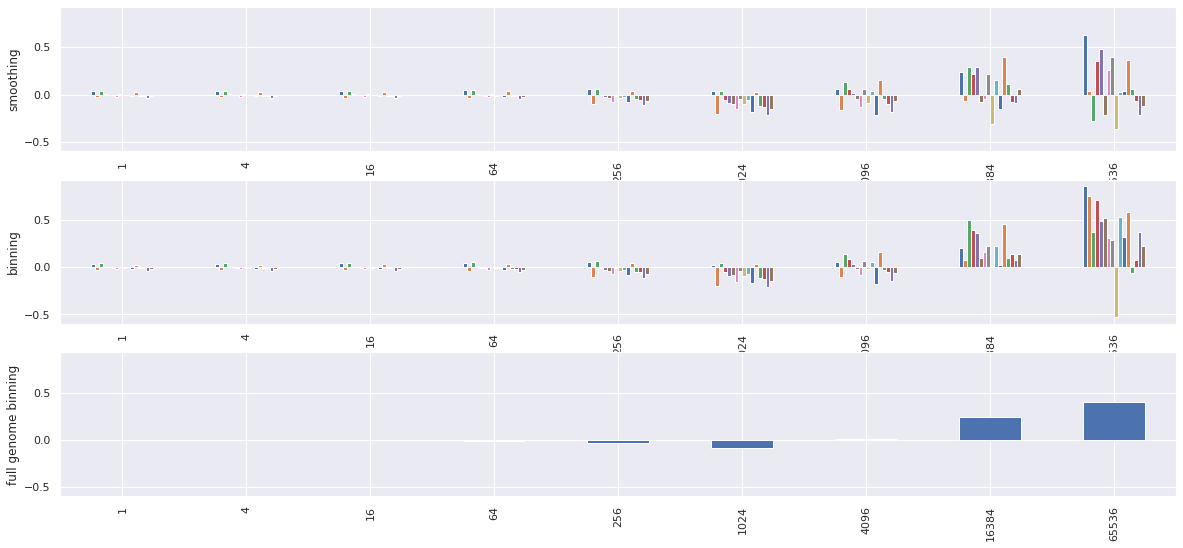

In [74]:
fig, axes = plt.subplots(3, 1, figsize=(20, 9), sharey=True)
corrs.plot(kind='bar', legend=False, ax=axes[0])
axes[0].set_ylabel('smoothing')
corrs_bin.plot(kind='bar', legend=False, ax=axes[1])
axes[1].set_ylabel('binning')
corrs_bin_concat.plot(kind='bar', legend=False, ax=axes[2])
axes[2].set_ylabel('full genome binning')

In [81]:
scale = 4**7
offsets = np.arange(0, scale, scale//16)
print(offsets)
corrs_bin2 = pd.DataFrame(index=offsets, columns=list(labels_pol.keys()))
corrs_bin_concat2 = pd.Series(index=offsets, dtype='float')
for offset in offsets:
    sigs1 = []
    sigs2 = []
    for chr_id in labels_pol.keys():
        sig1 = utils.bin_values(labels_pol[chr_id][offset:], scale)
        sig2 = utils.bin_values(labels_nuc[chr_id][offset:], scale)
        sigs1.append(sig1)
        sigs2.append(sig2)
        corrs_bin2.loc[offset, chr_id] = pearsonr(sig1, sig2)[0]
    sigs1 = np.concatenate(sigs1)
    sigs2 = np.concatenate(sigs2)
    corrs_bin_concat2.loc[offset] = pearsonr(sigs1, sigs2)[0]
corrs_bin2

[    0  1024  2048  3072  4096  5120  6144  7168  8192  9216 10240 11264
 12288 13312 14336 15360]


chrI     chrII    chrIII     chrIV      chrV     chrVI    chrVII  \
0      0.208061  0.074981  0.497691  0.391062  0.360465  0.096529  0.162375   
1024   0.230056  0.100755  0.566989  0.396693  0.356843  0.051184    0.1389   
2048   0.236304  0.113688  0.567623  0.367151  0.383277  0.059614  0.110582   
3072    0.25695  0.142594  0.568495  0.319052  0.392701  0.034032  0.105232   
4096   0.272025  0.157187  0.492794  0.306718  0.365143 -0.037522  0.072441   
5120   0.303032  0.120978  0.503844  0.312011  0.361205 -0.057859  0.076233   
6144    0.34054  0.110223  0.476854  0.301442  0.364342 -0.026078  0.109457   
7168   0.385758  0.110286  0.382547  0.299124  0.380762 -0.039983  0.129769   
8192   0.372653  0.088546  0.297945  0.301444  0.387409  0.058762  0.145649   
9216   0.379764   0.11359  0.241259  0.206138  0.373911 -0.159324 -0.011344   
10240  0.429926  0.118827  0.188793  0.198318  0.361124  -0.18668  0.006852   
11264  0.433104  0.109425  0.164757  0.231834  0.385714 -0.198373  0.049441   
12288   0.39296  0.207372  0.268383  0.227563  0.430792 -0.173905  0.154286   
13312  0.361422  0.211219  0.477141  0.253777  0.442035 -0.209942  0.169232   
14336  0.397275  0.191704  0.540549  0.280199  0.453721 -0.278039  0.175217   
15360  0.400778  0.201397  0.508294  0.317057  0.450531 -0.304471  0.158473   

        chrVIII     chrIX      chrX     chrXI    chrXII   chrXIII    chrXIV  \
0      0.227824  0.013765  0.222008   0.01951  0.452653   0.09594   0.13626   
1024    0.22551 -0.136911  0.214029  0.050764  0.460168  0.097843  0.135254   
2048   0.276284 -0.151911  0.213266  0.037175  0.466039  0.090821  0.092532   
3072   0.300377 -0.264135  0.214775 -0.001017  0.471834  0.093035  0.079097   
4096   0.322948 -0.397233  0.205858 -0.007097   0.46976  0.102857  0.103351   
5120   0.355522 -0.476563  0.173364 -0.012535  0.475714  0.089279  0.107569   
6144   0.339444 -0.468863  0.167571  0.090327  0.444959  0.111495  0.145602   
7168   0.323041 -0.423034  0.113661 -0.012585  0.452952  0.102512  0.151558   
8192     0.1995 -0.431075  0.086643 -0.031718  0.450377  0.105137  0.071451   
9216   0.195608 -0.390807  0.090733 -0.053908  0.431905  0.172598  0.036912   
10240  0.199444 -0.369341  0.069462 -0.020579  0.400155  0.228793  0.000085   
11264    0.2033  -0.35311  0.094162 -0.008574  0.400732  0.221537 -0.007067   
12288  0.174866 -0.293724  0.152402  0.011016  0.395988  0.264074  0.005813   
13312  0.166126 -0.235786  0.165664 -0.029242  0.400529    0.2613   0.00767   
14336  0.188695 -0.322789  0.126251 -0.031495   0.40649  0.232755  0.029471   
15360  0.175472 -0.234671   0.11133  0.004786  0.414961  0.121554  0.020236   

          chrXV    chrXVI  
0       0.07309    0.1375  
1024   0.103215   0.12874  
2048   0.135925    0.1217  
3072   0.141389  0.105916  
4096   0.156607  0.086483  
5120   0.182641  0.071514  
6144   0.205631   0.07171  
7168   0.199111  0.097737  
8192   0.208409  0.080892  
9216   0.218805  0.084189  
10240  0.088466  0.020582  
11264  0.065693 -0.067184  
12288  0.063502 -0.034656  
13312  0.048807 -0.030259  
14336  0.040017 -0.057103  
15360  0.052456 -0.033668

Text(0, 0.5, 'full genome binning')

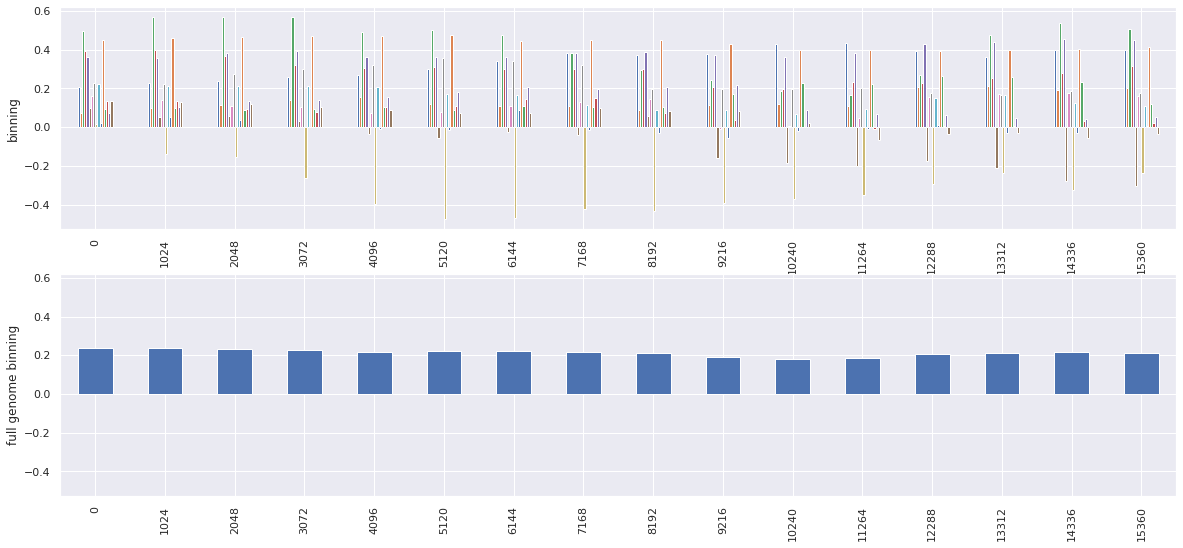

In [82]:
fig, axes = plt.subplots(2, 1, figsize=(20, 9), sharey=True)
corrs_bin2.plot(kind='bar', legend=False, ax=axes[0])
axes[0].set_ylabel('binning')
corrs_bin_concat2.plot(kind='bar', legend=False, ax=axes[1])
axes[1].set_ylabel('full genome binning')

chrI 14050
chrII 14854
chrIII 29687
chrIV 82680
chrV 26852
chrVI 9528
chrVII 31103
chrVIII 37126
chrIX 16077
chrX 27785
chrXI 5519
chrXII 94989
chrXIII 28686
chrXIV 16491
chrXV 25079
chrXVI 25075


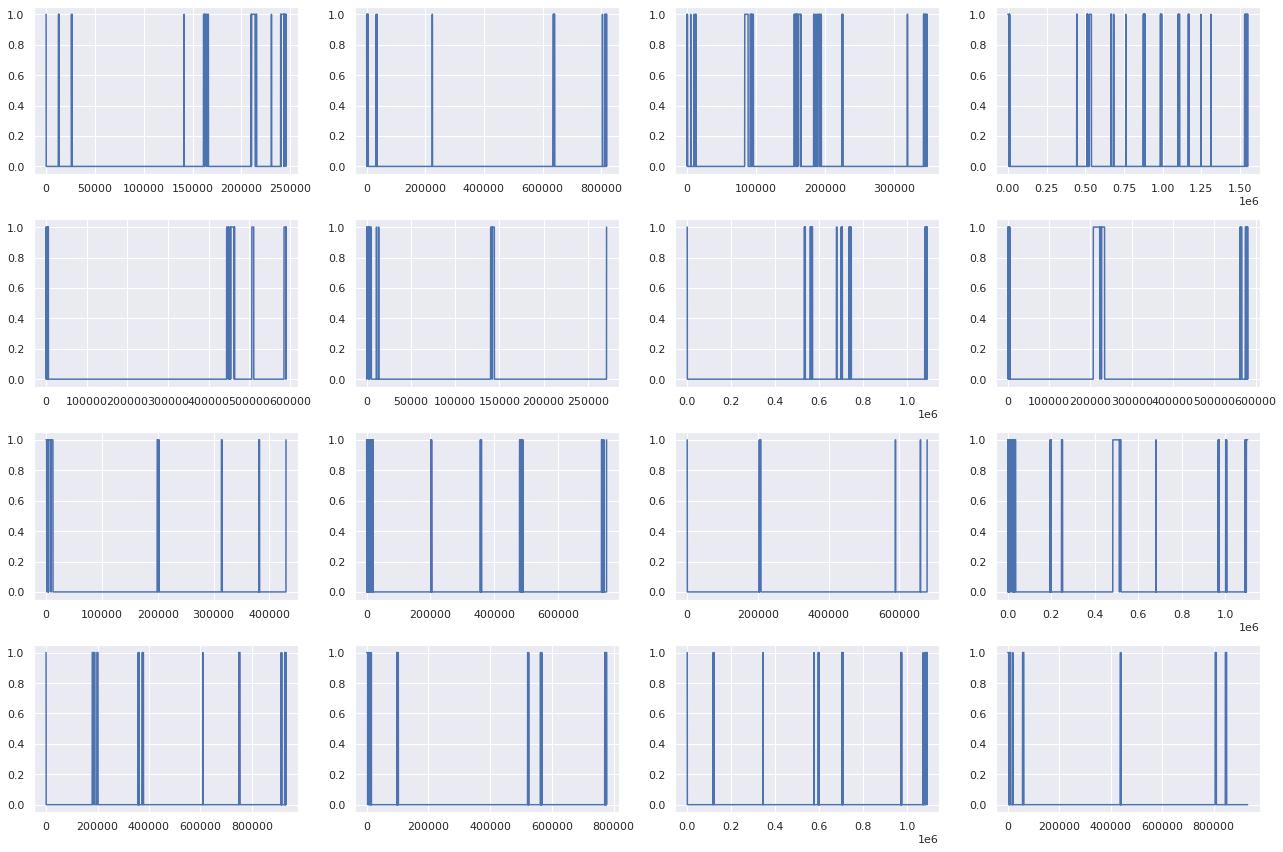

In [129]:
fig, axes = plt.subplots(4, 4, figsize=(18, 12), facecolor='w', layout='tight')
invalids = {}
for chr_id, ax in zip(labels_pol.keys(), axes.flatten()):
    invalids[chr_id] = (labels_pol[chr_id] == 0) & (labels_nuc[chr_id] == 0)
    print(chr_id, np.sum(invalids[chr_id]))
    ax.plot(invalids[chr_id])

In [144]:
peaks = {}
for chr_id in labels_nuc.keys():
    n_peaks = utils.nb_boolean_true_clusters(invalids[chr_id])
    peaks[chr_id] = utils.make_peaks(invalids[chr_id])
    print(n_peaks, peaks[chr_id].shape, np.sum(np.diff(invalids[chr_id])))
    try:
        assert len(peaks[chr_id]) == n_peaks
    except AssertionError:
        print(peaks[chr_id], len(labels_nuc[chr_id]))

22 (22, 2) 42
18 (18, 2) 34
34 (34, 2) 66
55 (55, 2) 108
16 (16, 2) 30
11 (11, 2) 20
23 (23, 2) 44
18 (18, 2) 34
14 (14, 2) 26
32 (32, 2) 62
8 (8, 2) 14
42 (42, 2) 82
20 (20, 2) 38
27 (27, 2) 52
26 (26, 2) 50
13 (13, 2) 25


In [ ]:
scale = 4**7
offsets = np.arange(0, scale, scale//16)
print(offsets)
corrs_bin2 = pd.DataFrame(index=offsets, columns=list(labels_pol.keys()))
corrs_bin_concat2 = pd.Series(index=offsets, dtype='float')
for offset in offsets:
    sigs1 = []
    sigs2 = []
    for chr_id in labels_pol.keys():
        sig1 = utils.bin_values(labels_pol[chr_id][offset:], scale)
        sig2 = utils.bin_values(labels_nuc[chr_id][offset:], scale)
        sigs1.append(sig1)
        sigs2.append(sig2)
        corrs_bin2.loc[offset, chr_id] = pearsonr(sig1, sig2)[0]
    sigs1 = np.concatenate(sigs1)
    sigs2 = np.concatenate(sigs2)
    corrs_bin_concat2.loc[offset] = pearsonr(sigs1, sigs2)[0]
corrs_bin2

In [9]:
lags = np.arange(0, 2000, 4)
autocorr_pol = {}
autocorr_nuc = {}
lagcorr_pol_nuc = {}
for chr_id, signal in labels_pol.items():
    autocorr_pol[chr_id] = utils.fast_sliding_correlation(signal, signal, lags)
    autocorr_nuc[chr_id] = utils.fast_sliding_correlation(labels_nuc[chr_id], labels_nuc[chr_id], lags)
    lagcorr_pol_nuc[chr_id] = utils.fast_sliding_correlation(signal, labels_nuc[chr_id], lags)

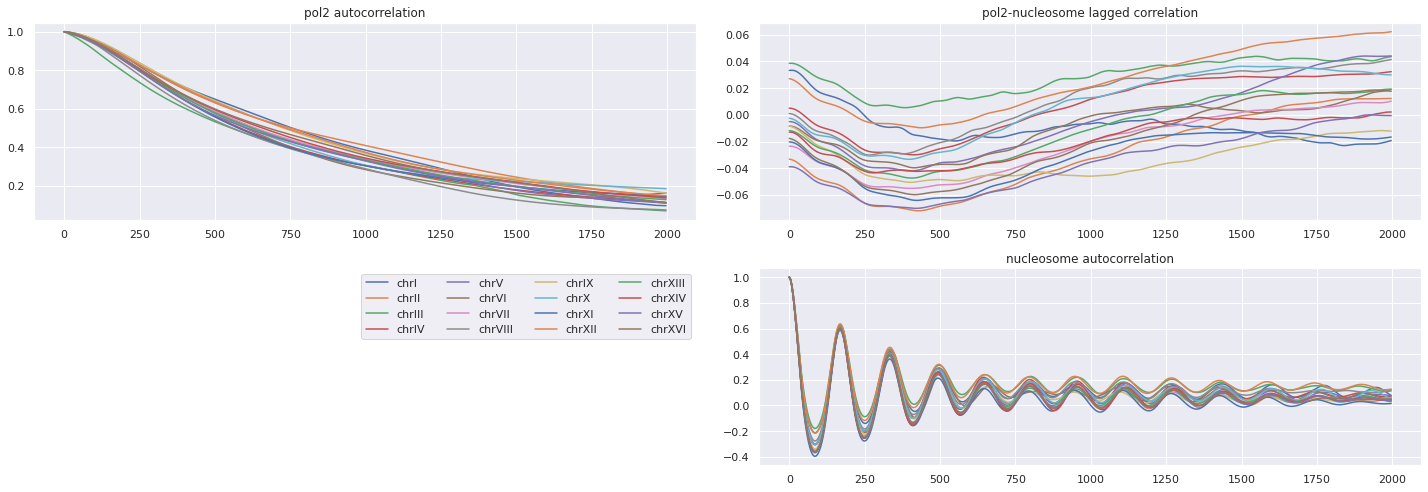

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(20, 7), facecolor='w', layout='tight')
for chr_id, corr in autocorr_pol.items():
    axes[0, 0].plot(lags, corr, label=chr_id)
    axes[0, 1].plot(lags, lagcorr_pol_nuc[chr_id])
    axes[1, 1].plot(lags, autocorr_nuc[chr_id])
axes[0, 0].set_title('pol2 autocorrelation')
axes[0, 1].set_title('pol2-nucleosome lagged correlation')
axes[1, 1].set_title('nucleosome autocorrelation')
h, l = plot_utils.add_legend(axes.flatten())
axes[1, 0].legend(h, l, ncol=4)
axes[1, 0].set_axis_off()

In [6]:
lags = np.arange(0, 5000, 10)
lag_cors = {}
for chr_id, signal in labels_pol.items():
    lag_cors[chr_id] = utils.fast_sliding_correlation(signal, signal, lags)

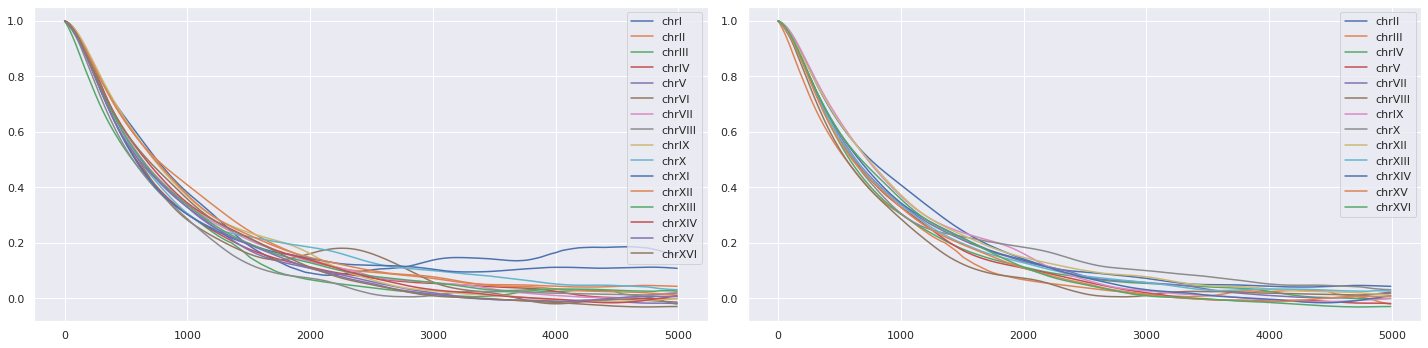

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), facecolor='w', layout='tight')
for chr_id, corr in lag_cors.items():
    axes[0].plot(lags, corr, label=chr_id)
    if chr_id not in ['chrI', 'chrVI', 'chrXI']:
        axes[1].plot(lags, corr, label=chr_id)
for ax in axes:
    ax.legend()

In [59]:
lags = np.arange(0, 1000, 2)
lag_cors = {}
for chr_id, signal in labels_nuc.items():
    lag_cors[chr_id] = utils.fast_sliding_correlation(signal, signal, lags)

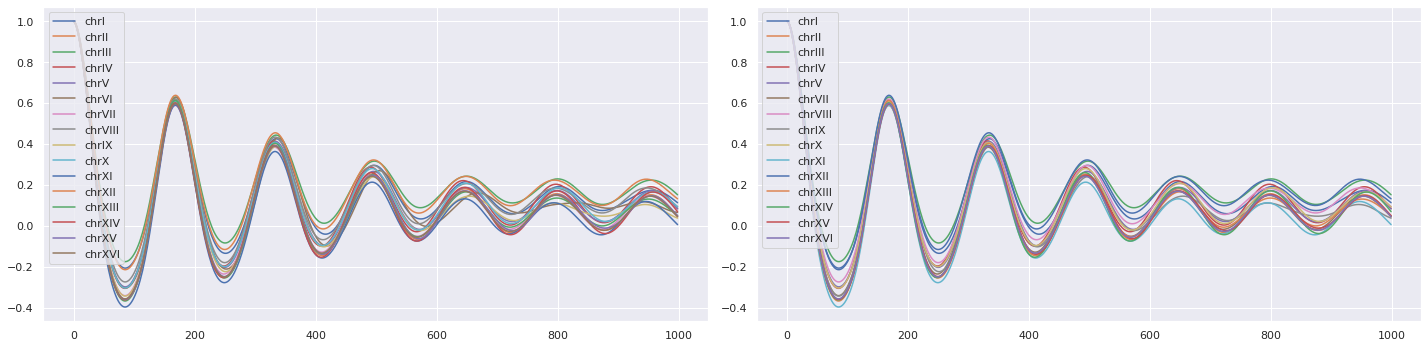

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), facecolor='w', layout='tight')
for chr_id, corr in lag_cors.items():
    axes[0].plot(lags, corr, label=chr_id)
    if chr_id not in ['chrVI']:
        axes[1].plot(lags, corr, label=chr_id)
for ax in axes:
    ax.legend()

In [4]:
lags = np.arange(0, 5000, 10)
lag_cors = {}
for chr_id, signal in labels_pol.items():
    lag_cors[chr_id] = utils.fast_sliding_correlation(signal, labels_nuc[chr_id], lags)

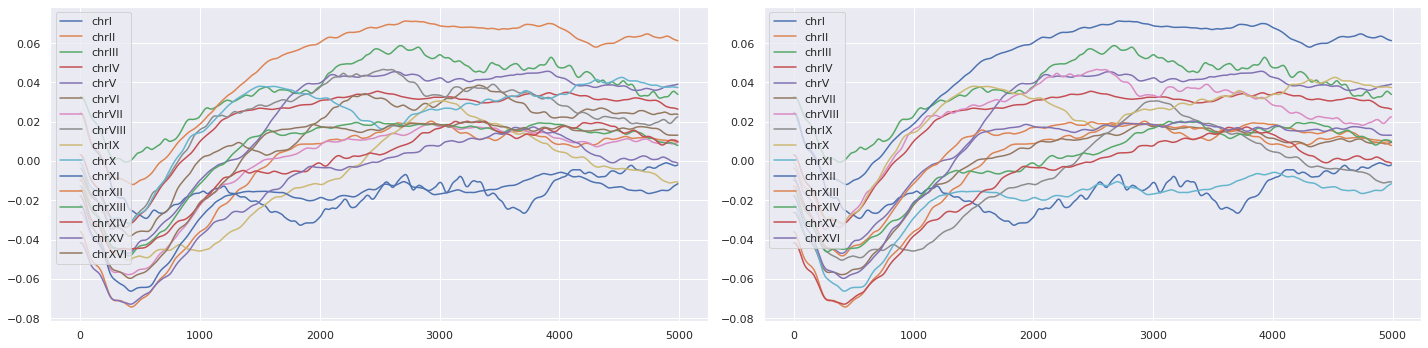

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), facecolor='w', layout='tight')
for chr_id, corr in lag_cors.items():
    axes[0].plot(lags, corr, label=chr_id)
    if chr_id not in ['chrVI']:
        axes[1].plot(lags, corr, label=chr_id)
for ax in axes:
    ax.legend()

369


<BarContainer object of 370 artists>

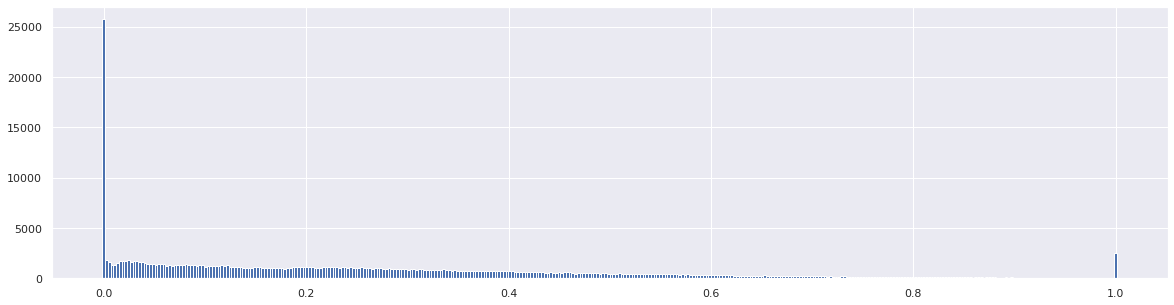

In [113]:
vals, counts = np.unique(labels_nuc['chrI'], return_counts=True)
step = vals[1]
print(len(vals) - 1)
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.bar(vals, counts, width=step)

<AxesSubplot:ylabel='Density'>

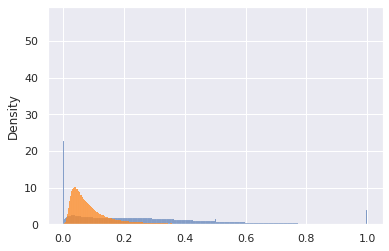

In [117]:
sns.histplot(np.concatenate(list(labels_nuc.values())), stat='density')
sns.histplot(np.concatenate(list(labels_pol.values())), stat='density', color=colors[1])

In [120]:
print((np.concatenate(list(labels_nuc.values())) == 0).sum())
print((np.concatenate(list(labels_pol.values())) == 0).sum())
print(((np.concatenate(list(labels_pol.values())) == 0) & (np.concatenate(list(labels_nuc.values())) == 0)).sum())
print(sum(len(v) for v in labels_nuc.values()))

716313
495099
485581
12189794


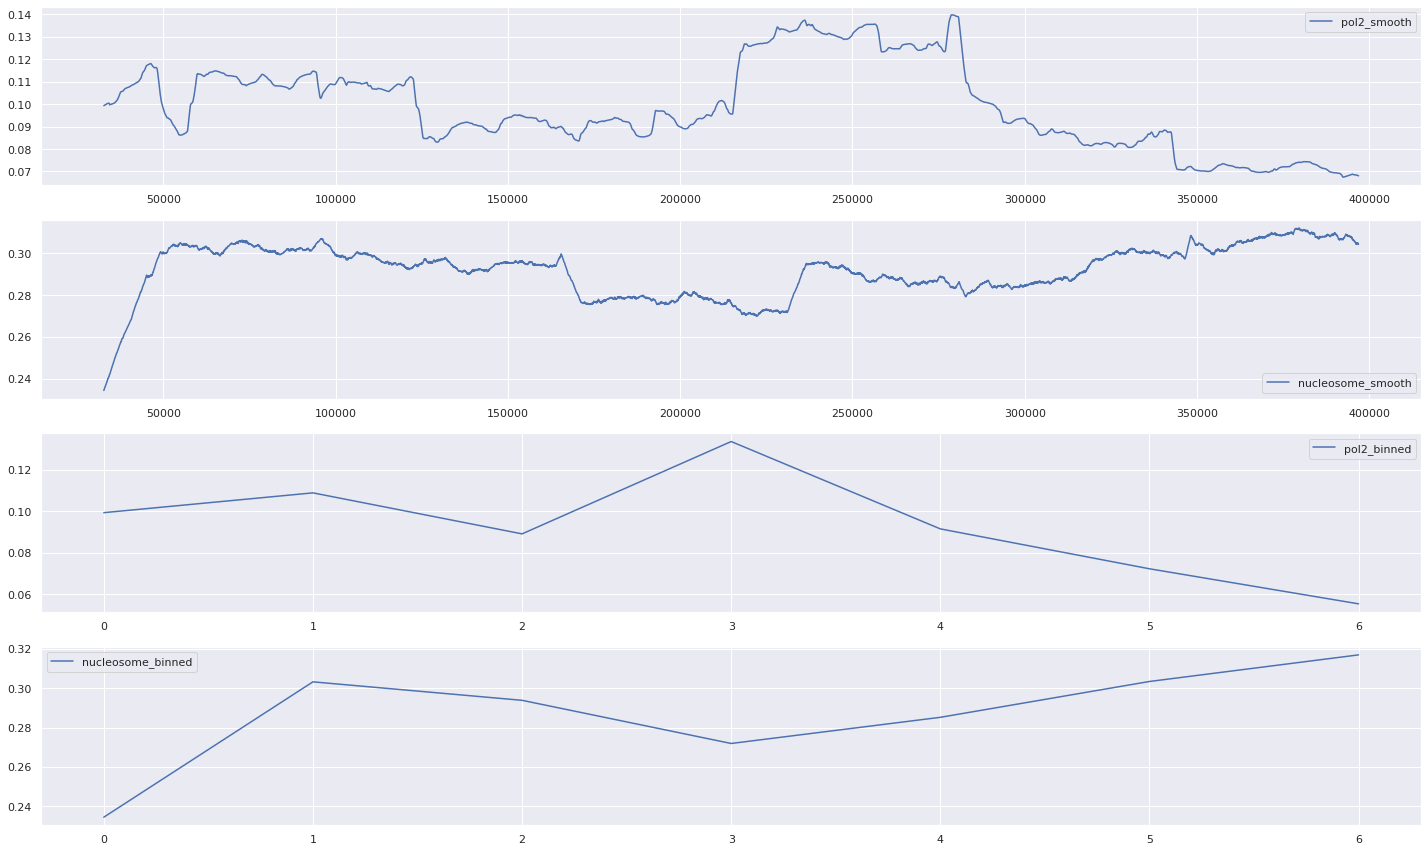

In [95]:
chr_id = 'chrIX' # 'chrIV'
start = 0 # 38912
stop = 2_000_000 # 40960
scale = 4**8
offset = 0
resolution = 1 # scale // 10
stop = min(stop, len(labels_pol[chr_id]))
midlen = 128*8
fig, axes = plt.subplots(4, 1, figsize=(20, 12), facecolor='w', layout='tight')
axes[0].plot(np.arange(start + scale//2, stop - scale//2, resolution), utils.smooth(labels_pol[chr_id], scale, padding='valid')[start:stop-scale+scale%2:resolution], label='pol2_smooth')
axes[1].plot(np.arange(start + scale//2, stop - scale//2, resolution), utils.smooth(labels_nuc[chr_id], scale, padding='valid')[start:stop-scale+scale%2:resolution], label='nucleosome_smooth')
axes[2].plot(utils.bin_values(labels_pol[chr_id][offset:], scale), label='pol2_binned')
axes[3].plot(utils.bin_values(labels_nuc[chr_id][offset:], scale), label='nucleosome_binned')
# ax.plot(np.arange(start, stop), preds_pol[chr_id][start:stop], label='ref_preds')
# sep = start + midlen - (start - midlen//2) % midlen
# while sep < stop:
#     ax.axvline(sep, color='k', linestyle='--')
#     sep += midlen
for ax in axes:
    ax.legend()

In [47]:
winsize = 2048
head_interval = 128
offset = 0
one_hots = utils.strided_sliding_window_view(
    one_hot_yeast[chr_id][start+offset:stop+offset+head_interval-1],
    (winsize, 4),
    winsize//2,
    head_interval).reshape(-1, winsize, 4)
one_hots.shape

(128, 2048, 4)

In [57]:
winsize = 2048
head_start = 8
offset = -128*8
one_hots = utils.sliding_window_view(
    one_hot_yeast[chr_id][start+offset:stop+offset+winsize-1],
    (winsize, 4)).reshape(-1, winsize, 4)
one_hots.shape

(2048, 2048, 4)

In [58]:
grads, preds = get_gradients(model_pol, one_hots, predict=True, head_start=8, n_heads=1)
preds_t = preds.T.ravel()
print(preds.shape)

(2048,)


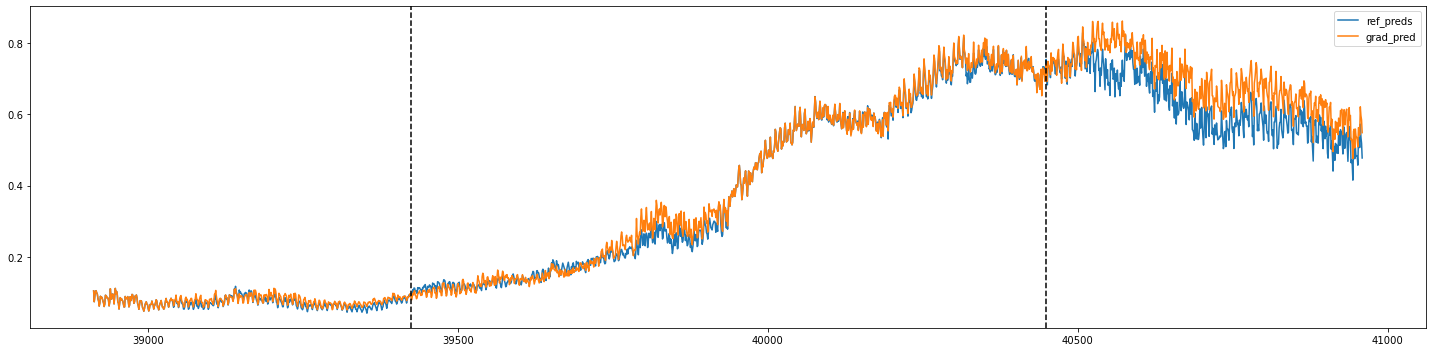

In [60]:
chr_id = 'chrIV'
start = 38912
stop = 40960
midlen = 128*8
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')
ax.plot(np.arange(start, stop), preds_pol[chr_id][start:stop], label='ref_preds')
# ax.plot(np.arange(start + midlen//2, stop - midlen//2), preds_t, label='grad_pred')
ax.plot(np.arange(start, stop), preds_t, label='grad_pred')
sep = start + midlen - (start - midlen//2) % midlen
while sep < stop:
    ax.axvline(sep, color='k', linestyle='--')
    sep += midlen
ax.legend()

In [61]:
print(grads.shape)
grads_proj = grads - grads.mean(axis=-1, keepdims=True)
print(grads_proj.shape)
grads_seq = grads[one_hots].reshape(grads.shape[:-1])
print(grads_seq.shape)
grads_proj_seq = grads_proj[one_hots].reshape(grads.shape[:-1])
print(grads_proj_seq.shape)

(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048)
(2048, 2048)


<AxesSubplot:>

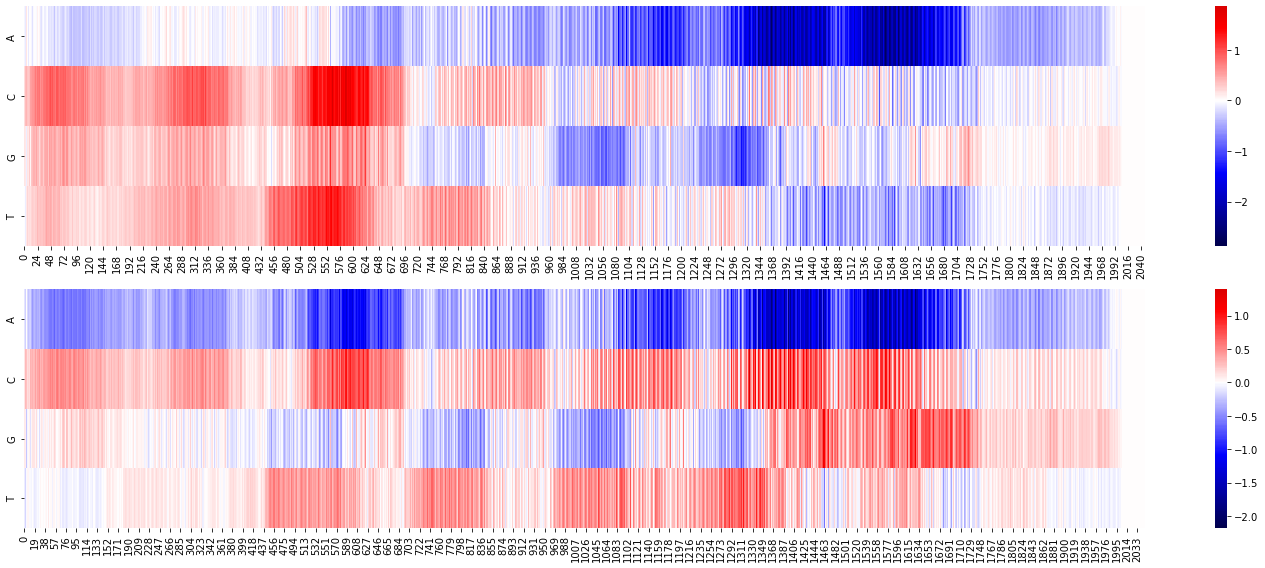

In [62]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), facecolor='w', layout='tight')
# sns.heatmap(grads_proj[0].T, ax=ax, cmap='seismic', center=0)
vmin = None # -2
sns.heatmap(grads.sum(axis=0).T, cmap='seismic', center=0, vmin=vmin, ax=axes[0],# cbar_ax=axes[0, 1],
            yticklabels=list('ACGT'))
sns.heatmap(grads_proj.sum(axis=0).T, cmap='seismic', center=0, vmin=vmin, ax=axes[1],# cbar_ax=axes[0, 1],
            yticklabels=list('ACGT'))

In [64]:
n_seqs = 2048
winsize = 2048
aligned_grads_seq = np.zeros((n_seqs, winsize+n_seqs), dtype='float32')
for j in range(n_seqs):
    aligned_grads_seq[j, j:j+winsize] = grads_seq[j]
print(aligned_grads_seq.shape)
aligned_grads_proj_seq = np.zeros((n_seqs, winsize+n_seqs), dtype='float32')
for j in range(n_seqs):
    aligned_grads_proj_seq[j, j:j+winsize] = grads_proj_seq[j]
print(aligned_grads_proj_seq.shape)

(2048, 4096)
(2048, 4096)


<AxesSubplot:>

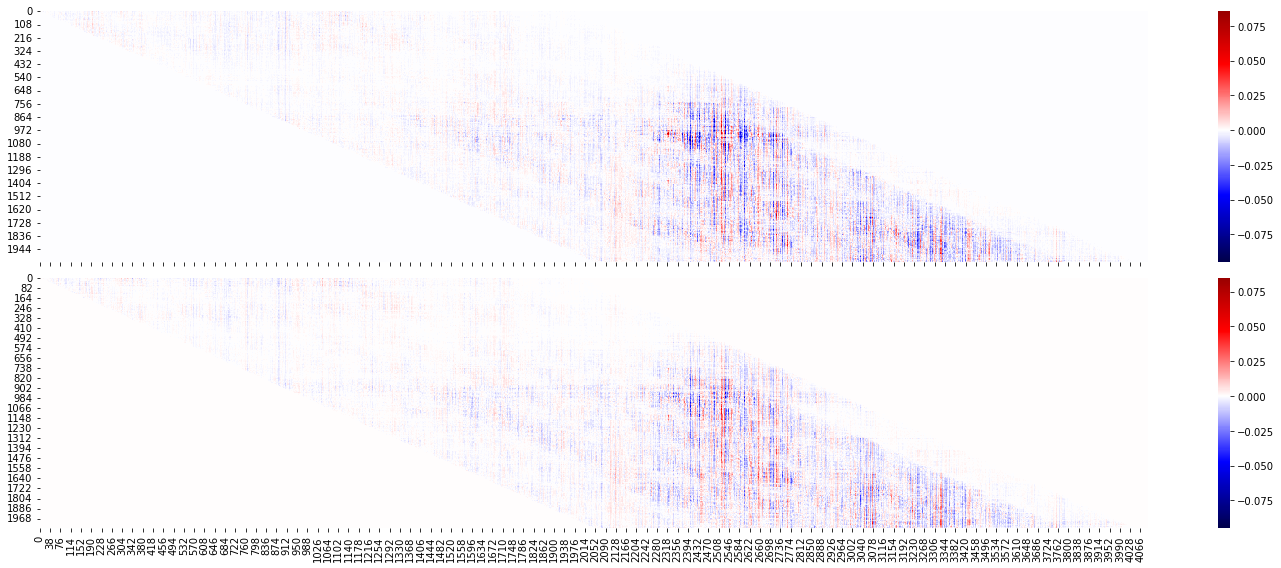

In [65]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), facecolor='w', layout='tight', sharex=True)
vmin = None # -2
sns.heatmap(aligned_grads_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[0])
sns.heatmap(aligned_grads_proj_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[1])

<AxesSubplot:>

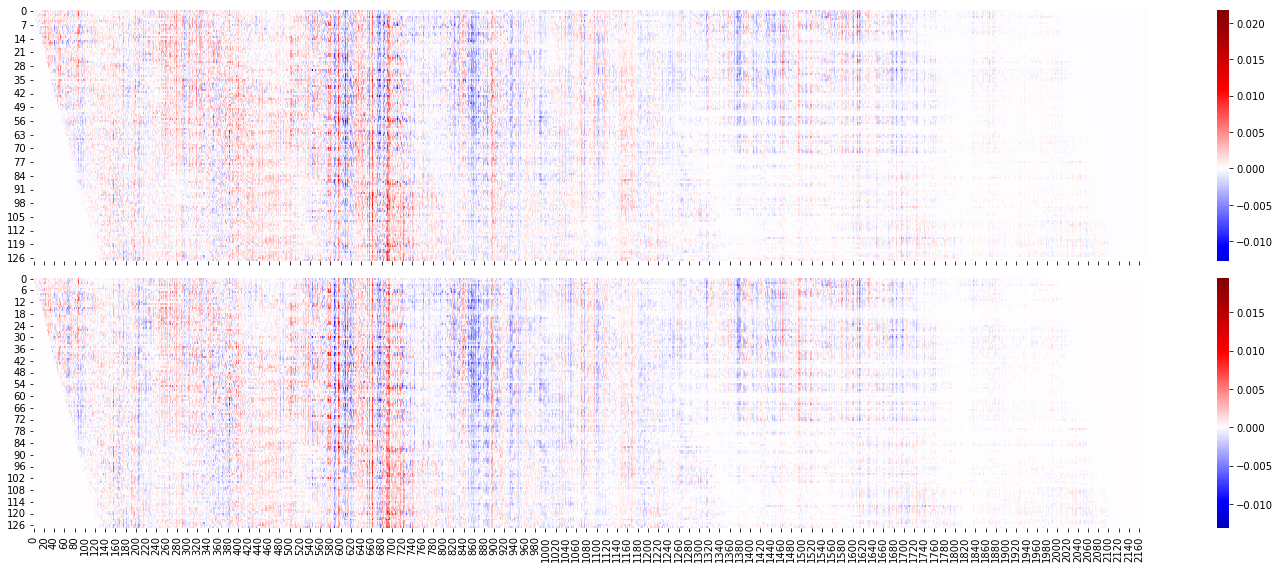

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), facecolor='w', layout='tight', sharex=True)
vmin = None # -2
sns.heatmap(aligned_grads_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[0])
sns.heatmap(aligned_grads_proj_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[1])

<AxesSubplot:>

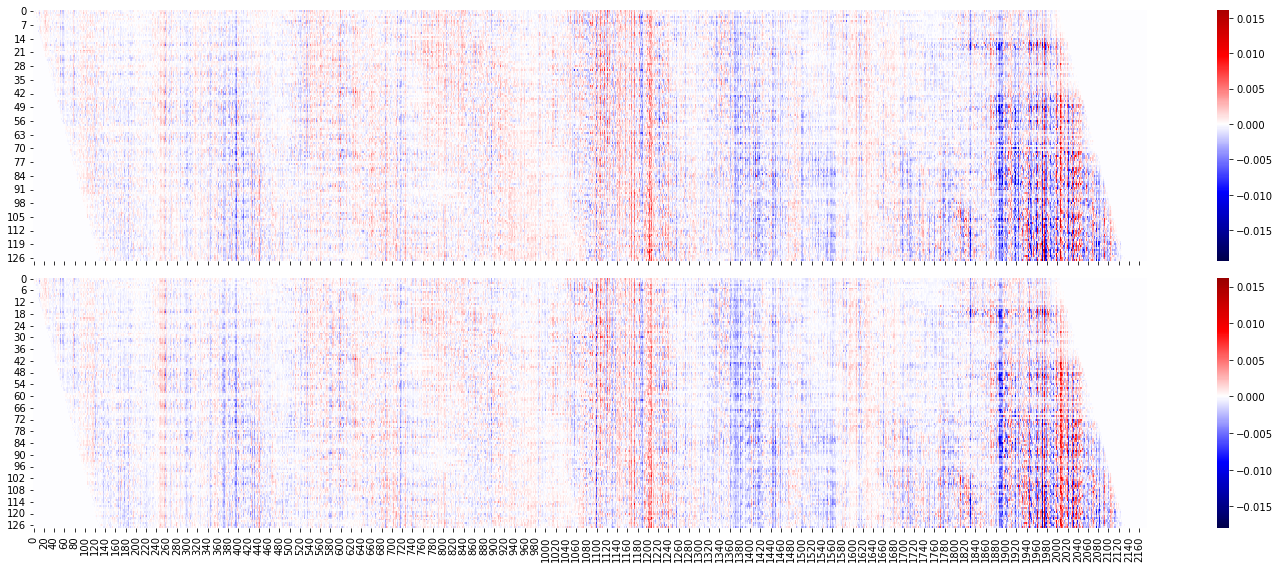

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), facecolor='w', layout='tight', sharex=True)
vmin = None # -2
sns.heatmap(aligned_grads_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[0])
sns.heatmap(aligned_grads_proj_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[1])

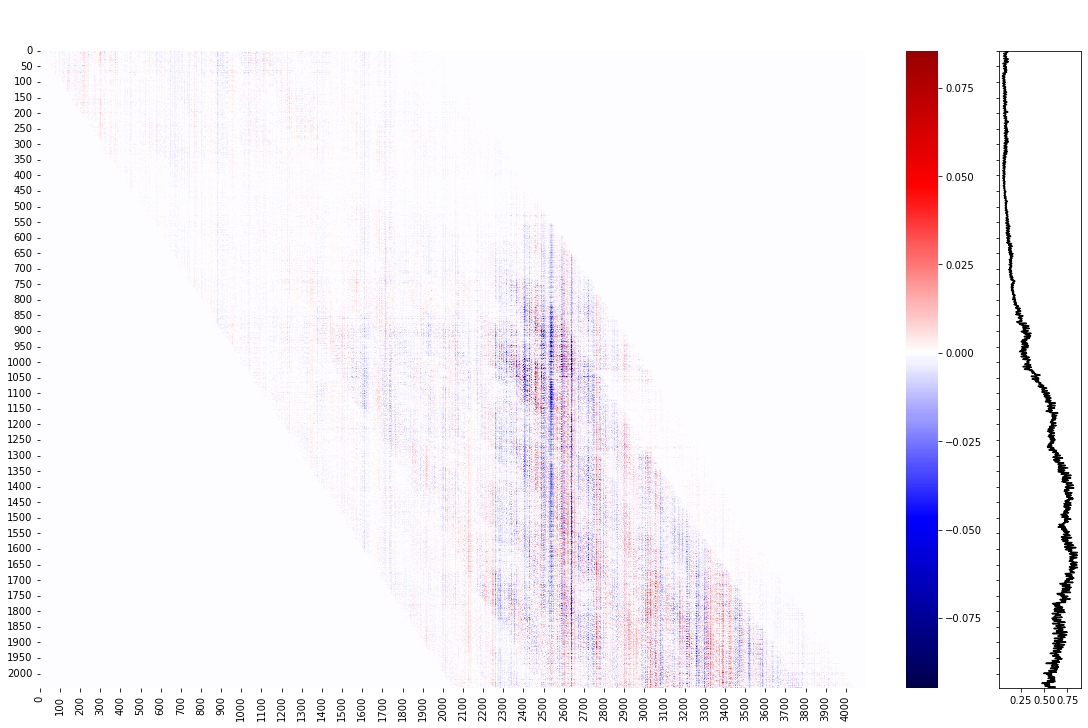

In [69]:
plot_start = 0
plot_stop = 4096
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey='row', sharex='col', layout='constrained',
                         gridspec_kw={'width_ratios': [10, 1],
                                      'height_ratios': [1, 20]})
fig.set_facecolor('w')
# lm.Logo(pd.DataFrame(one_hot_yeast['chrIV'][start+plot_start:start+plot_stop], columns=list('ACGT')), ax=axes[0, 0])
axes[0, 0].set_axis_off()
axes[0, 1].remove()
sns.heatmap(aligned_grads_seq[:, plot_start:plot_stop], cmap='seismic', center=0, ax=axes[1, 0],
            xticklabels=100, yticklabels=50)
axes[1, 1].plot(preds, np.arange(len(preds)), color='k', label='predictions')
plt.show()
plt.close()